In [1]:
!nvidia-smi

Thu Dec  8 20:46:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:08.0 Off |                    0 |
| N/A   29C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. 라이브러리 로딩

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import editdistance
import pickle
import time

from keras.optimizers import SGD

from crnn_model import CRNN
from crnn_data import InputGenerator
from crnn_utils import decode
from utils.training import Logger, ModelSnapshot

Using TensorFlow backend.


# 2. Target Value(라벨) 생성

## (1) JSON file load

In [4]:
import json

with open('./korean_printed_sentence.json', encoding='UTF8') as f:
  printed = json.load(f)

## (2) GTUtility 생성

In [5]:
import numpy as np
import json
import os

from ssd_data import BaseGTUtility

class GTUtility(BaseGTUtility):
    """Utility for COCO-Text dataset.

    # Arguments
        data_path: Path to ground truth and image data.
        validation: Boolean for using training or validation set.
        polygon: Return oriented boxes defined by their four corner points.
            Required by SegLink...
        only_with_label: Add only boxes if text labels are available.
    """
    
    def __init__(self, data_path, validation=False, polygon=False, only_with_label=True):
        test = False

        self.data_path = data_path
        gt_path = data_path
        image_path = os.path.join(data_path, 'printed')
        self.gt_path = gt_path
        self.image_path = image_path
        self.classes = ['Background', 'Text']

        self.image_names = []
        self.data = []
        self.text = []
        
        with open(os.path.join(gt_path, 'korean_printed_sentence.json'), encoding='UTF8') as f:
            gt_data = json.load(f)

        image_list = list(data['id'] for data in printed['images'])

        for img_id in image_list: # images

            if len(img_id) > 0:
                image_name = next((item['file_name'] for item in gt_data['images'] if item['id'] == img_id), None)
                img_width = next((item['width'] for item in gt_data['images'] if item['id'] == img_id), None)
                img_height = next((item['height'] for item in gt_data['images'] if item['id'] == img_id), None)

                boxes = []
                text = []
                
                box = np.array([0, 0, 1, 1])
                boxes.append(box)

                txt = next((item['text'] for item in gt_data['annotations'] if item['id'] == img_id), None)
                text.append(txt)
                    
                if len(boxes) == 0:
                    continue
                
                boxes = np.asarray(boxes)
                    
                # append classes
                boxes = np.concatenate([boxes, np.ones([boxes.shape[0],1])], axis=1)
                
                self.image_names.append(image_name)
                self.data.append(boxes)
                self.text.append(text)

                print(image_name)
                
        self.init()

    def randomSplit(self, split=0.8):
      gtu1 = BaseGTUtility()
      gtu1.gt_path = self.gt_path
      gtu1.image_path = self.image_path
      gtu1.classes = self.classes

      gtu2 = BaseGTUtility()
      gtu2.gt_path = self.gt_path
      gtu2.image_pth = self.image_path
      gtu2.classes = self.classes

      n = int(round(split * len(self.image_names)))

      idx = np.arange(len(self.image_names))

      np.random.seed(0)

      np.random.shuffle(idx)

      train = idx[:n]
      val = idx[n:]

      gtu1.image_names = [self.image_names[t] for t in train]
      gtu2.image_names = [self.image_names[v] for v in val]

      gtu1.data = [self.data[t] for t in train]
      gtu2.data = [self.data[v] for v in val]

      if hasattr(self, 'text'):
        gtu1.text = [self.text[t] for t in train]
        gtu2.text = [self.text[v] for v in val]

      gtu1.init()
      gtu2.init()

      return gtu1, gtu2


if __name__ == '__main__':
    gt_util = GTUtility('./', validation=False, polygon=True, only_with_label=True)
    print(gt_util.data)



03343000.png
03343001.png
03343002.png
03343003.png
03343004.png
03343005.png
03343006.png
03343007.png
03343008.png
03343009.png
03343010.png
03343011.png
03343012.png
03343013.png
03343014.png
03343015.png
03343016.png
03343017.png
03343018.png
03343019.png
03343020.png
03343021.png
03343022.png
03343023.png
03343024.png
03343025.png
03343026.png
03343027.png
03343028.png
03343029.png
03343030.png
03343031.png
03343032.png
03343033.png
03343034.png
03343035.png
03343036.png
03343037.png
03343038.png
03343039.png
03343040.png
03343041.png
03343042.png
03343043.png
03343044.png
03343045.png
03343046.png
03343047.png
03343048.png
03343049.png
03343050.png
03343051.png
03343052.png
03343053.png
03343054.png
03343055.png
03343056.png
03343057.png
03343058.png
03343059.png
03343060.png
03343061.png
03343062.png
03343063.png
03343064.png
03343065.png
03343066.png
03343067.png
03343068.png
03343069.png
03343070.png
03343071.png
03343072.png
03343073.png
03343074.png
03343075.png
03343076.png

03344396.png
03344397.png
03344398.png
03344399.png
03344400.png
03344401.png
03344402.png
03344403.png
03344404.png
03344405.png
03344406.png
03344407.png
03344408.png
03344409.png
03344410.png
03344411.png
03344412.png
03344413.png
03344414.png
03344415.png
03344416.png
03344417.png
03344418.png
03344419.png
03344420.png
03344421.png
03344422.png
03344423.png
03344424.png
03344425.png
03344426.png
03344427.png
03344428.png
03344429.png
03344430.png
03344431.png
03344432.png
03344433.png
03344434.png
03344435.png
03344436.png
03344437.png
03344438.png
03344439.png
03344440.png
03344441.png
03344442.png
03344443.png
03344444.png
03344445.png
03344446.png
03344447.png
03344448.png
03344449.png
03344450.png
03344451.png
03344452.png
03344453.png
03344454.png
03344455.png
03344456.png
03344457.png
03344458.png
03344459.png
03344460.png
03344461.png
03344462.png
03344463.png
03344464.png
03344465.png
03344466.png
03344467.png
03344468.png
03344469.png
03344470.png
03344471.png
03344472.png

03345993.png
03345994.png
03345995.png
03345996.png
03345997.png
03345998.png
03345999.png
03346000.png
03346001.png
03346002.png
03346003.png
03346004.png
03346005.png
03346006.png
03346007.png
03346008.png
03346009.png
03346010.png
03346011.png
03346012.png
03346013.png
03346014.png
03346015.png
03346016.png
03346017.png
03346018.png
03346019.png
03346020.png
03346021.png
03346022.png
03346023.png
03346024.png
03346025.png
03346026.png
03346027.png
03346028.png
03346029.png
03346030.png
03346031.png
03346032.png
03346033.png
03346034.png
03346035.png
03346036.png
03346037.png
03346038.png
03346039.png
03346040.png
03346041.png
03346042.png
03346043.png
03346044.png
03346045.png
03346046.png
03346047.png
03346048.png
03346049.png
03346050.png
03346051.png
03346052.png
03346053.png
03346054.png
03346055.png
03346056.png
03346057.png
03346058.png
03346059.png
03346060.png
03346061.png
03346062.png
03346063.png
03346064.png
03346065.png
03346066.png
03346067.png
03346068.png
03346069.png

03347231.png
03347232.png
03347233.png
03347234.png
03347235.png
03347236.png
03347237.png
03347238.png
03347239.png
03347240.png
03347241.png
03347242.png
03347243.png
03347244.png
03347245.png
03347246.png
03347247.png
03347248.png
03347249.png
03347250.png
03347251.png
03347252.png
03347253.png
03347254.png
03347255.png
03347256.png
03347257.png
03347258.png
03347259.png
03347260.png
03347261.png
03347262.png
03347263.png
03347264.png
03347265.png
03347266.png
03347267.png
03347268.png
03347269.png
03347270.png
03347271.png
03347272.png
03347273.png
03347274.png
03347275.png
03347276.png
03347277.png
03347278.png
03347279.png
03347280.png
03347281.png
03347282.png
03347283.png
03347284.png
03347285.png
03347286.png
03347287.png
03347288.png
03347289.png
03347290.png
03347291.png
03347292.png
03347293.png
03347294.png
03347295.png
03347296.png
03347297.png
03347298.png
03347299.png
03347300.png
03347301.png
03347302.png
03347303.png
03347304.png
03347305.png
03347306.png
03347307.png

03348269.png
03348270.png
03348271.png
03348272.png
03348273.png
03348274.png
03348275.png
03348276.png
03348277.png
03348278.png
03348279.png
03348280.png
03348281.png
03348282.png
03348283.png
03348284.png
03348285.png
03348286.png
03348287.png
03348288.png
03348289.png
03348290.png
03348291.png
03348292.png
03348293.png
03348294.png
03348295.png
03348296.png
03348297.png
03348298.png
03348299.png
03348300.png
03348301.png
03348302.png
03348303.png
03348304.png
03348305.png
03348306.png
03348307.png
03348308.png
03348309.png
03348310.png
03348311.png
03348312.png
03348313.png
03348314.png
03348315.png
03348316.png
03348317.png
03348318.png
03348319.png
03348320.png
03348321.png
03348322.png
03348323.png
03348324.png
03348325.png
03348326.png
03348327.png
03348328.png
03348329.png
03348330.png
03348331.png
03348332.png
03348333.png
03348334.png
03348335.png
03348336.png
03348337.png
03348338.png
03348339.png
03348340.png
03348341.png
03348342.png
03348343.png
03348344.png
03348345.png

03349083.png
03349084.png
03349085.png
03349086.png
03349087.png
03349088.png
03349089.png
03349090.png
03349091.png
03349092.png
03349093.png
03349094.png
03349095.png
03349096.png
03349097.png
03349098.png
03349099.png
03349100.png
03349101.png
03349102.png
03349103.png
03349104.png
03349105.png
03349106.png
03349107.png
03349108.png
03349109.png
03349110.png
03349111.png
03349112.png
03349113.png
03349114.png
03349115.png
03349116.png
03349117.png
03349118.png
03349119.png
03349120.png
03349121.png
03349122.png
03349123.png
03349124.png
03349125.png
03349126.png
03349127.png
03349128.png
03349129.png
03349130.png
03349131.png
03349132.png
03349133.png
03349134.png
03349135.png
03349136.png
03349137.png
03349138.png
03349139.png
03349140.png
03349141.png
03349142.png
03349143.png
03349144.png
03349145.png
03349146.png
03349147.png
03349148.png
03349149.png
03349150.png
03349151.png
03349152.png
03349153.png
03349154.png
03349155.png
03349156.png
03349157.png
03349158.png
03349159.png

03351494.png
03351495.png
03351496.png
03351497.png
03351498.png
03351499.png
03351500.png
03351501.png
03351502.png
03351503.png
03351504.png
03351505.png
03351506.png
03351507.png
03351508.png
03351509.png
03351510.png
03351511.png
03351512.png
03351513.png
03351514.png
03351515.png
03351516.png
03351517.png
03351518.png
03351519.png
03351520.png
03351521.png
03351522.png
03351523.png
03351524.png
03351525.png
03351526.png
03351527.png
03351528.png
03351529.png
03351530.png
03351531.png
03351532.png
03351533.png
03351534.png
03351535.png
03351536.png
03351537.png
03351538.png
03351539.png
03351540.png
03351541.png
03351542.png
03351543.png
03351544.png
03351545.png
03351546.png
03351547.png
03351548.png
03351549.png
03351550.png
03351551.png
03351552.png
03351553.png
03351554.png
03351555.png
03351556.png
03351557.png
03351558.png
03351559.png
03351560.png
03351561.png
03351562.png
03351563.png
03351564.png
03351565.png
03351566.png
03351567.png
03351568.png
03351569.png
03351570.png

03352394.png
03352395.png
03352396.png
03352397.png
03352398.png
03352399.png
03352400.png
03352401.png
03352402.png
03352403.png
03352404.png
03352405.png
03352406.png
03352407.png
03352408.png
03352409.png
03352410.png
03352411.png
03352412.png
03352413.png
03352414.png
03352415.png
03352416.png
03352417.png
03352418.png
03352419.png
03352420.png
03352421.png
03352422.png
03352423.png
03352424.png
03352425.png
03352426.png
03352427.png
03352428.png
03352429.png
03352430.png
03352431.png
03352432.png
03352433.png
03352434.png
03352435.png
03352436.png
03352437.png
03352438.png
03352439.png
03352440.png
03352441.png
03352442.png
03352443.png
03352444.png
03352445.png
03352446.png
03352447.png
03352448.png
03352449.png
03352450.png
03352451.png
03352452.png
03352453.png
03352454.png
03352455.png
03352456.png
03352457.png
03352458.png
03352459.png
03352460.png
03352461.png
03352462.png
03352463.png
03352464.png
03352465.png
03352466.png
03352467.png
03352468.png
03352469.png
03352470.png

03353637.png
03353638.png
03353639.png
03353640.png
03353641.png
03353642.png
03353643.png
03353644.png
03353645.png
03353646.png
03353647.png
03353648.png
03353649.png
03353650.png
03353651.png
03353652.png
03353653.png
03353654.png
03353655.png
03353656.png
03353657.png
03353658.png
03353659.png
03353660.png
03353661.png
03353662.png
03353663.png
03353664.png
03353665.png
03353666.png
03353667.png
03353668.png
03353669.png
03353670.png
03353671.png
03353672.png
03353673.png
03353674.png
03353675.png
03353676.png
03353677.png
03353678.png
03353679.png
03353680.png
03353681.png
03353682.png
03353683.png
03353684.png
03353685.png
03353686.png
03353687.png
03353688.png
03353689.png
03353690.png
03353691.png
03353692.png
03353693.png
03353694.png
03353695.png
03353696.png
03353697.png
03353698.png
03353699.png
03353700.png
03353701.png
03353702.png
03353703.png
03353704.png
03353705.png
03353706.png
03353707.png
03353708.png
03353709.png
03353710.png
03353711.png
03353712.png
03353713.png

03354596.png
03354597.png
03354598.png
03354599.png
03354600.png
03354601.png
03354602.png
03354603.png
03354604.png
03354605.png
03354606.png
03354607.png
03354608.png
03354609.png
03354610.png
03354611.png
03354612.png
03354613.png
03354614.png
03354615.png
03354616.png
03354617.png
03354618.png
03354619.png
03354620.png
03354621.png
03354622.png
03354623.png
03354624.png
03354625.png
03354626.png
03354627.png
03354628.png
03354629.png
03354630.png
03354631.png
03354632.png
03354633.png
03354634.png
03354635.png
03354636.png
03354637.png
03354638.png
03354639.png
03354640.png
03354641.png
03354642.png
03354643.png
03354644.png
03354645.png
03354646.png
03354647.png
03354648.png
03354649.png
03354650.png
03354651.png
03354652.png
03354653.png
03354654.png
03354655.png
03354656.png
03354657.png
03354658.png
03354659.png
03354660.png
03354661.png
03354662.png
03354663.png
03354664.png
03354665.png
03354666.png
03354667.png
03354668.png
03354669.png
03354670.png
03354671.png
03354672.png

03355260.png
03355261.png
03355262.png
03355263.png
03355264.png
03355265.png
03355266.png
03355267.png
03355268.png
03355269.png
03355270.png
03355271.png
03355272.png
03355273.png
03355274.png
03355275.png
03355276.png
03355277.png
03355278.png
03355279.png
03355280.png
03355281.png
03355282.png
03355283.png
03355284.png
03355285.png
03355286.png
03355287.png
03355288.png
03355289.png
03355290.png
03355291.png
03355292.png
03355293.png
03355294.png
03355295.png
03355296.png
03355297.png
03355298.png
03355299.png
03355300.png
03355301.png
03355302.png
03355303.png
03355304.png
03355305.png
03355306.png
03355307.png
03355308.png
03355309.png
03355310.png
03355311.png
03355312.png
03355313.png
03355314.png
03355315.png
03355316.png
03355317.png
03355318.png
03355319.png
03355320.png
03355321.png
03355322.png
03355323.png
03355324.png
03355325.png
03355326.png
03355327.png
03355328.png
03355329.png
03355330.png
03355331.png
03355332.png
03355333.png
03355334.png
03355335.png
03355336.png

03355997.png
03355998.png
03355999.png
03356000.png
03356001.png
03356002.png
03356003.png
03356004.png
03356005.png
03356006.png
03356007.png
03356008.png
03356009.png
03356010.png
03356011.png
03356012.png
03356013.png
03356014.png
03356015.png
03356016.png
03356017.png
03356018.png
03356019.png
03356020.png
03356021.png
03356022.png
03356023.png
03356024.png
03356025.png
03356026.png
03356027.png
03356028.png
03356029.png
03356030.png
03356031.png
03356032.png
03356033.png
03356034.png
03356035.png
03356036.png
03356037.png
03356038.png
03356039.png
03356040.png
03356041.png
03356042.png
03356043.png
03356044.png
03356045.png
03356046.png
03356047.png
03356048.png
03356049.png
03356050.png
03356051.png
03356052.png
03356053.png
03356054.png
03356055.png
03356056.png
03356057.png
03356058.png
03356059.png
03356060.png
03356061.png
03356062.png
03356063.png
03356064.png
03356065.png
03356066.png
03356067.png
03356068.png
03356069.png
03356070.png
03356071.png
03356072.png
03356073.png

03357092.png
03357093.png
03357094.png
03357095.png
03357096.png
03357097.png
03357098.png
03357099.png
03357100.png
03357101.png
03357102.png
03357103.png
03357104.png
03357105.png
03357106.png
03357107.png
03357108.png
03357109.png
03357110.png
03357111.png
03357112.png
03357113.png
03357114.png
03357115.png
03357116.png
03357117.png
03357118.png
03357119.png
03357120.png
03357121.png
03357122.png
03357123.png
03357124.png
03357125.png
03357126.png
03357127.png
03357128.png
03357129.png
03357130.png
03357131.png
03357132.png
03357133.png
03357134.png
03357135.png
03357136.png
03357137.png
03357138.png
03357139.png
03357140.png
03357141.png
03357142.png
03357143.png
03357144.png
03357145.png
03357146.png
03357147.png
03357148.png
03357149.png
03357150.png
03357151.png
03357152.png
03357153.png
03357154.png
03357155.png
03357156.png
03357157.png
03357158.png
03357159.png
03357160.png
03357161.png
03357162.png
03357163.png
03357164.png
03357165.png
03357166.png
03357167.png
03357168.png

03358107.png
03358108.png
03358109.png
03358110.png
03358111.png
03358112.png
03358113.png
03358114.png
03358115.png
03358116.png
03358117.png
03358118.png
03358119.png
03358120.png
03358121.png
03358122.png
03358123.png
03358124.png
03358125.png
03358126.png
03358127.png
03358128.png
03358129.png
03358130.png
03358131.png
03358132.png
03358133.png
03358134.png
03358135.png
03358136.png
03358137.png
03358138.png
03358139.png
03358140.png
03358141.png
03358142.png
03358143.png
03358144.png
03358145.png
03358146.png
03358147.png
03358148.png
03358149.png
03358150.png
03358151.png
03358152.png
03358153.png
03358154.png
03358155.png
03358156.png
03358157.png
03358158.png
03358159.png
03358160.png
03358161.png
03358162.png
03358163.png
03358164.png
03358165.png
03358166.png
03358167.png
03358168.png
03358169.png
03358170.png
03358171.png
03358172.png
03358173.png
03358174.png
03358175.png
03358176.png
03358177.png
03358178.png
03358179.png
03358180.png
03358181.png
03358182.png
03358183.png

03358931.png
03358932.png
03358933.png
03358934.png
03358935.png
03358936.png
03358937.png
03358938.png
03358939.png
03358940.png
03358941.png
03358942.png
03358943.png
03358944.png
03358945.png
03358946.png
03358947.png
03358948.png
03358949.png
03358950.png
03358951.png
03358952.png
03358953.png
03358954.png
03358955.png
03358956.png
03358957.png
03358958.png
03358959.png
03358960.png
03358961.png
03358962.png
03358963.png
03358964.png
03358965.png
03358966.png
03358967.png
03358968.png
03358969.png
03358970.png
03358971.png
03358972.png
03358973.png
03358974.png
03358975.png
03358976.png
03358977.png
03358978.png
03358979.png
03358980.png
03358981.png
03358982.png
03358983.png
03358984.png
03358985.png
03358986.png
03358987.png
03358988.png
03358989.png
03358990.png
03358991.png
03358992.png
03358993.png
03358994.png
03358995.png
03358996.png
03358997.png
03358998.png
03358999.png
03359000.png
03359001.png
03359002.png
03359003.png
03359004.png
03359005.png
03359006.png
03359007.png

03360126.png
03360127.png
03360128.png
03360129.png
03360130.png
03360131.png
03360132.png
03360133.png
03360134.png
03360135.png
03360136.png
03360137.png
03360138.png
03360139.png
03360140.png
03360141.png
03360142.png
03360143.png
03360144.png
03360145.png
03360146.png
03360147.png
03360148.png
03360149.png
03360150.png
03360151.png
03360152.png
03360153.png
03360154.png
03360155.png
03360156.png
03360157.png
03360158.png
03360159.png
03360160.png
03360161.png
03360162.png
03360163.png
03360164.png
03360165.png
03360166.png
03360167.png
03360168.png
03360169.png
03360170.png
03360171.png
03360172.png
03360173.png
03360174.png
03360175.png
03360176.png
03360177.png
03360178.png
03360179.png
03360180.png
03360181.png
03360182.png
03360183.png
03360184.png
03360185.png
03360186.png
03360187.png
03360188.png
03360189.png
03360190.png
03360191.png
03360192.png
03360193.png
03360194.png
03360195.png
03360196.png
03360197.png
03360198.png
03360199.png
03360200.png
03360201.png
03360202.png

03361934.png
03361935.png
03361936.png
03361937.png
03361938.png
03361939.png
03361940.png
03361941.png
03361942.png
03361943.png
03361944.png
03361945.png
03361946.png
03361947.png
03361948.png
03361949.png
03361950.png
03361951.png
03361952.png
03361953.png
03361954.png
03361955.png
03361956.png
03361957.png
03361958.png
03361959.png
03361960.png
03361961.png
03361962.png
03361963.png
03361964.png
03361965.png
03361966.png
03361967.png
03361968.png
03361969.png
03361970.png
03361971.png
03361972.png
03361973.png
03361974.png
03361975.png
03361976.png
03361977.png
03361978.png
03361979.png
03361980.png
03361981.png
03361982.png
03361983.png
03361984.png
03361985.png
03361986.png
03361987.png
03361988.png
03361989.png
03361990.png
03361991.png
03361992.png
03361993.png
03361994.png
03361995.png
03361996.png
03361997.png
03361998.png
03361999.png
03362000.png
03362001.png
03362002.png
03362003.png
03362004.png
03362005.png
03362006.png
03362007.png
03362008.png
03362009.png
03362010.png

03362697.png
03362698.png
03362699.png
03362700.png
03362701.png
03362702.png
03362703.png
03362704.png
03362705.png
03362706.png
03362707.png
03362708.png
03362709.png
03362710.png
03362711.png
03362712.png
03362713.png
03362714.png
03362715.png
03362716.png
03362717.png
03362718.png
03362719.png
03362720.png
03362721.png
03362722.png
03362723.png
03362724.png
03362725.png
03362726.png
03362727.png
03362728.png
03362729.png
03362730.png
03362731.png
03362732.png
03362733.png
03362734.png
03362735.png
03362736.png
03362737.png
03362738.png
03362739.png
03362740.png
03362741.png
03362742.png
03362743.png
03362744.png
03362745.png
03362746.png
03362747.png
03362748.png
03362749.png
03362750.png
03362751.png
03362752.png
03362753.png
03362754.png
03362755.png
03362756.png
03362757.png
03362758.png
03362759.png
03362760.png
03362761.png
03362762.png
03362763.png
03362764.png
03362765.png
03362766.png
03362767.png
03362768.png
03362769.png
03362770.png
03362771.png
03362772.png
03362773.png

03363846.png
03363847.png
03363848.png
03363849.png
03363850.png
03363851.png
03363852.png
03363853.png
03363854.png
03363855.png
03363856.png
03363857.png
03363858.png
03363859.png
03363860.png
03363861.png
03363862.png
03363863.png
03363864.png
03363865.png
03363866.png
03363867.png
03363868.png
03363869.png
03363870.png
03363871.png
03363872.png
03363873.png
03363874.png
03363875.png
03363876.png
03363877.png
03363878.png
03363879.png
03363880.png
03363881.png
03363882.png
03363883.png
03363884.png
03363885.png
03363886.png
03363887.png
03363888.png
03363889.png
03363890.png
03363891.png
03363892.png
03363893.png
03363894.png
03363895.png
03363896.png
03363897.png
03363898.png
03363899.png
03363900.png
03363901.png
03363902.png
03363903.png
03363904.png
03363905.png
03363906.png
03363907.png
03363908.png
03363909.png
03363910.png
03363911.png
03363912.png
03363913.png
03363914.png
03363915.png
03363916.png
03363917.png
03363918.png
03363919.png
03363920.png
03363921.png
03363922.png

03364598.png
03364599.png
03364600.png
03364601.png
03364602.png
03364603.png
03364604.png
03364605.png
03364606.png
03364607.png
03364608.png
03364609.png
03364610.png
03364611.png
03364612.png
03364613.png
03364614.png
03364615.png
03364616.png
03364617.png
03364618.png
03364619.png
03364620.png
03364621.png
03364622.png
03364623.png
03364624.png
03364625.png
03364626.png
03364627.png
03364628.png
03364629.png
03364630.png
03364631.png
03364632.png
03364633.png
03364634.png
03364635.png
03364636.png
03364637.png
03364638.png
03364639.png
03364640.png
03364641.png
03364642.png
03364643.png
03364644.png
03364645.png
03364646.png
03364647.png
03364648.png
03364649.png
03364650.png
03364651.png
03364652.png
03364653.png
03364654.png
03364655.png
03364656.png
03364657.png
03364658.png
03364659.png
03364660.png
03364661.png
03364662.png
03364663.png
03364664.png
03364665.png
03364666.png
03364667.png
03364668.png
03364669.png
03364670.png
03364671.png
03364672.png
03364673.png
03364674.png

03365246.png
03365247.png
03365248.png
03365249.png
03365250.png
03365251.png
03365252.png
03365253.png
03365254.png
03365255.png
03365256.png
03365257.png
03365258.png
03365259.png
03365260.png
03365261.png
03365262.png
03365263.png
03365264.png
03365265.png
03365266.png
03365267.png
03365268.png
03365269.png
03365270.png
03365271.png
03365272.png
03365273.png
03365274.png
03365275.png
03365276.png
03365277.png
03365278.png
03365279.png
03365280.png
03365281.png
03365282.png
03365283.png
03365284.png
03365285.png
03365286.png
03365287.png
03365288.png
03365289.png
03365290.png
03365291.png
03365292.png
03365293.png
03365294.png
03365295.png
03365296.png
03365297.png
03365298.png
03365299.png
03365300.png
03365301.png
03365302.png
03365303.png
03365304.png
03365305.png
03365306.png
03365307.png
03365308.png
03365309.png
03365310.png
03365311.png
03365312.png
03365313.png
03365314.png
03365315.png
03365316.png
03365317.png
03365318.png
03365319.png
03365320.png
03365321.png
03365322.png

03365887.png
03365888.png
03365889.png
03365890.png
03365891.png
03365892.png
03365893.png
03365894.png
03365895.png
03365896.png
03365897.png
03365898.png
03365899.png
03365900.png
03365901.png
03365902.png
03365903.png
03365904.png
03365905.png
03365906.png
03365907.png
03365908.png
03365909.png
03365910.png
03365911.png
03365912.png
03365913.png
03365914.png
03365915.png
03365916.png
03365917.png
03365918.png
03365919.png
03365920.png
03365921.png
03365922.png
03365923.png
03365924.png
03365925.png
03365926.png
03365927.png
03365928.png
03365929.png
03365930.png
03365931.png
03365932.png
03365933.png
03365934.png
03365935.png
03365936.png
03365937.png
03365938.png
03365939.png
03365940.png
03365941.png
03365942.png
03365943.png
03365944.png
03365945.png
03365946.png
03365947.png
03365948.png
03365949.png
03365950.png
03365951.png
03365952.png
03365953.png
03365954.png
03365955.png
03365956.png
03365957.png
03365958.png
03365959.png
03365960.png
03365961.png
03365962.png
03365963.png

03366528.png
03366529.png
03366530.png
03366531.png
03366532.png
03366533.png
03366534.png
03366535.png
03366536.png
03366537.png
03366538.png
03366539.png
03366540.png
03366541.png
03366542.png
03366543.png
03366544.png
03366545.png
03366546.png
03366547.png
03366548.png
03366549.png
03366550.png
03366551.png
03366552.png
03366553.png
03366554.png
03366555.png
03366556.png
03366557.png
03366558.png
03366559.png
03366560.png
03366561.png
03366562.png
03366563.png
03366564.png
03366565.png
03366566.png
03366567.png
03366568.png
03366569.png
03366570.png
03366571.png
03366572.png
03366573.png
03366574.png
03366575.png
03366576.png
03366577.png
03366578.png
03366579.png
03366580.png
03366581.png
03366582.png
03366583.png
03366584.png
03366585.png
03366586.png
03366587.png
03366588.png
03366589.png
03366590.png
03366591.png
03366592.png
03366593.png
03366594.png
03366595.png
03366596.png
03366597.png
03366598.png
03366599.png
03366600.png
03366601.png
03366602.png
03366603.png
03366604.png

03367175.png
03367176.png
03367177.png
03367178.png
03367179.png
03367180.png
03367181.png
03367182.png
03367183.png
03367184.png
03367185.png
03367186.png
03367187.png
03367188.png
03367189.png
03367190.png
03367191.png
03367192.png
03367193.png
03367194.png
03367195.png
03367196.png
03367197.png
03367198.png
03367199.png
03367200.png
03367201.png
03367202.png
03367203.png
03367204.png
03367205.png
03367206.png
03367207.png
03367208.png
03367209.png
03367210.png
03367211.png
03367212.png
03367213.png
03367214.png
03367215.png
03367216.png
03367217.png
03367218.png
03367219.png
03367220.png
03367221.png
03367222.png
03367223.png
03367224.png
03367225.png
03367226.png
03367227.png
03367228.png
03367229.png
03367230.png
03367231.png
03367232.png
03367233.png
03367234.png
03367235.png
03367236.png
03367237.png
03367238.png
03367239.png
03367240.png
03367241.png
03367242.png
03367243.png
03367244.png
03367245.png
03367246.png
03367247.png
03367248.png
03367249.png
03367250.png
03367251.png

03367807.png
03367808.png
03367809.png
03367810.png
03367811.png
03367812.png
03367813.png
03367814.png
03367815.png
03367816.png
03367817.png
03367818.png
03367819.png
03367820.png
03367821.png
03367822.png
03367823.png
03367824.png
03367825.png
03367826.png
03367827.png
03367828.png
03367829.png
03367830.png
03367831.png
03367832.png
03367833.png
03367834.png
03367835.png
03367836.png
03367837.png
03367838.png
03367839.png
03367840.png
03367841.png
03367842.png
03367843.png
03367844.png
03367845.png
03367846.png
03367847.png
03367848.png
03367849.png
03367850.png
03367851.png
03367852.png
03367853.png
03367854.png
03367855.png
03367856.png
03367857.png
03367858.png
03367859.png
03367860.png
03367861.png
03367862.png
03367863.png
03367864.png
03367865.png
03367866.png
03367867.png
03367868.png
03367869.png
03367870.png
03367871.png
03367872.png
03367873.png
03367874.png
03367875.png
03367876.png
03367877.png
03367878.png
03367879.png
03367880.png
03367881.png
03367882.png
03367883.png

03368471.png
03368472.png
03368473.png
03368474.png
03368475.png
03368476.png
03368477.png
03368478.png
03368479.png
03368480.png
03368481.png
03368482.png
03368483.png
03368484.png
03368485.png
03368486.png
03368487.png
03368488.png
03368489.png
03368490.png
03368491.png
03368492.png
03368493.png
03368494.png
03368495.png
03368496.png
03368497.png
03368498.png
03368499.png
03368500.png
03368501.png
03368502.png
03368503.png
03368504.png
03368505.png
03368506.png
03368507.png
03368508.png
03368509.png
03368510.png
03368511.png
03368512.png
03368513.png
03368514.png
03368515.png
03368516.png
03368517.png
03368518.png
03368519.png
03368520.png
03368521.png
03368522.png
03368523.png
03368524.png
03368525.png
03368526.png
03368527.png
03368528.png
03368529.png
03368530.png
03368531.png
03368532.png
03368533.png
03368534.png
03368535.png
03368536.png
03368537.png
03368538.png
03368539.png
03368540.png
03368541.png
03368542.png
03368543.png
03368544.png
03368545.png
03368546.png
03368547.png

03369140.png
03369141.png
03369142.png
03369143.png
03369144.png
03369145.png
03369146.png
03369147.png
03369148.png
03369149.png
03369150.png
03369151.png
03369152.png
03369153.png
03369154.png
03369155.png
03369156.png
03369157.png
03369158.png
03369159.png
03369160.png
03369161.png
03369162.png
03369163.png
03369164.png
03369165.png
03369166.png
03369167.png
03369168.png
03369169.png
03369170.png
03369171.png
03369172.png
03369173.png
03369174.png
03369175.png
03369176.png
03369177.png
03369178.png
03369179.png
03369180.png
03369181.png
03369182.png
03369183.png
03369184.png
03369185.png
03369186.png
03369187.png
03369188.png
03369189.png
03369190.png
03369191.png
03369192.png
03369193.png
03369194.png
03369195.png
03369196.png
03369197.png
03369198.png
03369199.png
03369200.png
03369201.png
03369202.png
03369203.png
03369204.png
03369205.png
03369206.png
03369207.png
03369208.png
03369209.png
03369210.png
03369211.png
03369212.png
03369213.png
03369214.png
03369215.png
03369216.png

03369802.png
03369803.png
03369804.png
03369805.png
03369806.png
03369807.png
03369808.png
03369809.png
03369810.png
03369811.png
03369812.png
03369813.png
03369814.png
03369815.png
03369816.png
03369817.png
03369818.png
03369819.png
03369820.png
03369821.png
03369822.png
03369823.png
03369824.png
03369825.png
03369826.png
03369827.png
03369828.png
03369829.png
03369830.png
03369831.png
03369832.png
03369833.png
03369834.png
03369835.png
03369836.png
03369837.png
03369838.png
03369839.png
03369840.png
03369841.png
03369842.png
03369843.png
03369844.png
03369845.png
03369846.png
03369847.png
03369848.png
03369849.png
03369850.png
03369851.png
03369852.png
03369853.png
03369854.png
03369855.png
03369856.png
03369857.png
03369858.png
03369859.png
03369860.png
03369861.png
03369862.png
03369863.png
03369864.png
03369865.png
03369866.png
03369867.png
03369868.png
03369869.png
03369870.png
03369871.png
03369872.png
03369873.png
03369874.png
03369875.png
03369876.png
03369877.png
03369878.png

03370439.png
03370440.png
03370441.png
03370442.png
03370443.png
03370444.png
03370445.png
03370446.png
03370447.png
03370448.png
03370449.png
03370450.png
03370451.png
03370452.png
03370453.png
03370454.png
03370455.png
03370456.png
03370457.png
03370458.png
03370459.png
03370460.png
03370461.png
03370462.png
03370463.png
03370464.png
03370465.png
03370466.png
03370467.png
03370468.png
03370469.png
03370470.png
03370471.png
03370472.png
03370473.png
03370474.png
03370475.png
03370476.png
03370477.png
03370478.png
03370479.png
03370480.png
03370481.png
03370482.png
03370483.png
03370484.png
03370485.png
03370486.png
03370487.png
03370488.png
03370489.png
03370490.png
03370491.png
03370492.png
03370493.png
03370494.png
03370495.png
03370496.png
03370497.png
03370498.png
03370499.png
03370500.png
03370501.png
03370502.png
03370503.png
03370504.png
03370505.png
03370506.png
03370507.png
03370508.png
03370509.png
03370510.png
03370511.png
03370512.png
03370513.png
03370514.png
03370515.png

03371093.png
03371094.png
03371095.png
03371096.png
03371097.png
03371098.png
03371099.png
03371100.png
03371101.png
03371102.png
03371103.png
03371104.png
03371105.png
03371106.png
03371107.png
03371108.png
03371109.png
03371110.png
03371111.png
03371112.png
03371113.png
03371114.png
03371115.png
03371116.png
03371117.png
03371118.png
03371119.png
03371120.png
03371121.png
03371122.png
03371123.png
03371124.png
03371125.png
03371126.png
03371127.png
03371128.png
03371129.png
03371130.png
03371131.png
03371132.png
03371133.png
03371134.png
03371135.png
03371136.png
03371137.png
03371138.png
03371139.png
03371140.png
03371141.png
03371142.png
03371143.png
03371144.png
03371145.png
03371146.png
03371147.png
03371148.png
03371149.png
03371150.png
03371151.png
03371152.png
03371153.png
03371154.png
03371155.png
03371156.png
03371157.png
03371158.png
03371159.png
03371160.png
03371161.png
03371162.png
03371163.png
03371164.png
03371165.png
03371166.png
03371167.png
03371168.png
03371169.png

03371734.png
03371735.png
03371736.png
03371737.png
03371738.png
03371739.png
03371740.png
03371741.png
03371742.png
03371743.png
03371744.png
03371745.png
03371746.png
03371747.png
03371748.png
03371749.png
03371750.png
03371751.png
03371752.png
03371753.png
03371754.png
03371755.png
03371756.png
03371757.png
03371758.png
03371759.png
03371760.png
03371761.png
03371762.png
03371763.png
03371764.png
03371765.png
03371766.png
03371767.png
03371768.png
03371769.png
03371770.png
03371771.png
03371772.png
03371773.png
03371774.png
03371775.png
03371776.png
03371777.png
03371778.png
03371779.png
03371780.png
03371781.png
03371782.png
03371783.png
03371784.png
03371785.png
03371786.png
03371787.png
03371788.png
03371789.png
03371790.png
03371791.png
03371792.png
03371793.png
03371794.png
03371795.png
03371796.png
03371797.png
03371798.png
03371799.png
03371800.png
03371801.png
03371802.png
03371803.png
03371804.png
03371805.png
03371806.png
03371807.png
03371808.png
03371809.png
03371810.png

03372387.png
03372388.png
03372389.png
03372390.png
03372391.png
03372392.png
03372393.png
03372394.png
03372395.png
03372396.png
03372397.png
03372398.png
03372399.png
03372400.png
03372401.png
03372402.png
03372403.png
03372404.png
03372405.png
03372406.png
03372407.png
03372408.png
03372409.png
03372410.png
03372411.png
03372412.png
03372413.png
03372414.png
03372415.png
03372416.png
03372417.png
03372418.png
03372419.png
03372420.png
03372421.png
03372422.png
03372423.png
03372424.png
03372425.png
03372426.png
03372427.png
03372428.png
03372429.png
03372430.png
03372431.png
03372432.png
03372433.png
03372434.png
03372435.png
03372436.png
03372437.png
03372438.png
03372439.png
03372440.png
03372441.png
03372442.png
03372443.png
03372444.png
03372445.png
03372446.png
03372447.png
03372448.png
03372449.png
03372450.png
03372451.png
03372452.png
03372453.png
03372454.png
03372455.png
03372456.png
03372457.png
03372458.png
03372459.png
03372460.png
03372461.png
03372462.png
03372463.png

03373033.png
03373034.png
03373035.png
03373036.png
03373037.png
03373038.png
03373039.png
03373040.png
03373041.png
03373042.png
03373043.png
03373044.png
03373045.png
03373046.png
03373047.png
03373048.png
03373049.png
03373050.png
03373051.png
03373052.png
03373053.png
03373054.png
03373055.png
03373056.png
03373057.png
03373058.png
03373059.png
03373060.png
03373061.png
03373062.png
03373063.png
03373064.png
03373065.png
03373066.png
03373067.png
03373068.png
03373069.png
03373070.png
03373071.png
03373072.png
03373073.png
03373074.png
03373075.png
03373076.png
03373077.png
03373078.png
03373079.png
03373080.png
03373081.png
03373082.png
03373083.png
03373084.png
03373085.png
03373086.png
03373087.png
03373088.png
03373089.png
03373090.png
03373091.png
03373092.png
03373093.png
03373094.png
03373095.png
03373096.png
03373097.png
03373098.png
03373099.png
03373100.png
03373101.png
03373102.png
03373103.png
03373104.png
03373105.png
03373106.png
03373107.png
03373108.png
03373109.png

03373688.png
03373689.png
03373690.png
03373691.png
03373692.png
03373693.png
03373694.png
03373695.png
03373696.png
03373697.png
03373698.png
03373699.png
03373700.png
03373701.png
03373702.png
03373703.png
03373704.png
03373705.png
03373706.png
03373707.png
03373708.png
03373709.png
03373710.png
03373711.png
03373712.png
03373713.png
03373714.png
03373715.png
03373716.png
03373717.png
03373718.png
03373719.png
03373720.png
03373721.png
03373722.png
03373723.png
03373724.png
03373725.png
03373726.png
03373727.png
03373728.png
03373729.png
03373730.png
03373731.png
03373732.png
03373733.png
03373734.png
03373735.png
03373736.png
03373737.png
03373738.png
03373739.png
03373740.png
03373741.png
03373742.png
03373743.png
03373744.png
03373745.png
03373746.png
03373747.png
03373748.png
03373749.png
03373750.png
03373751.png
03373752.png
03373753.png
03373754.png
03373755.png
03373756.png
03373757.png
03373758.png
03373759.png
03373760.png
03373761.png
03373762.png
03373763.png
03373764.png

03374329.png
03374330.png
03374331.png
03374332.png
03374333.png
03374334.png
03374335.png
03374336.png
03374337.png
03374338.png
03374339.png
03374340.png
03374341.png
03374342.png
03374343.png
03374344.png
03374345.png
03374346.png
03374347.png
03374348.png
03374349.png
03374350.png
03374351.png
03374352.png
03374353.png
03374354.png
03374355.png
03374356.png
03374357.png
03374358.png
03374359.png
03374360.png
03374361.png
03374362.png
03374363.png
03374364.png
03374365.png
03374366.png
03374367.png
03374368.png
03374369.png
03374370.png
03374371.png
03374372.png
03374373.png
03374374.png
03374375.png
03374376.png
03374377.png
03374378.png
03374379.png
03374380.png
03374381.png
03374382.png
03374383.png
03374384.png
03374385.png
03374386.png
03374387.png
03374388.png
03374389.png
03374390.png
03374391.png
03374392.png
03374393.png
03374394.png
03374395.png
03374396.png
03374397.png
03374398.png
03374399.png
03374400.png
03374401.png
03374402.png
03374403.png
03374404.png
03374405.png

03374985.png
03374986.png
03374987.png
03374988.png
03374989.png
03374990.png
03374991.png
03374992.png
03374993.png
03374994.png
03374995.png
03374996.png
03374997.png
03374998.png
03374999.png
03375000.png
03375001.png
03375002.png
03375003.png
03375004.png
03375005.png
03375006.png
03375007.png
03375008.png
03375009.png
03375010.png
03375011.png
03375012.png
03375013.png
03375014.png
03375015.png
03375016.png
03375017.png
03375018.png
03375019.png
03375020.png
03375021.png
03375022.png
03375023.png
03375024.png
03375025.png
03375026.png
03375027.png
03375028.png
03375029.png
03375030.png
03375031.png
03375032.png
03375033.png
03375034.png
03375035.png
03375036.png
03375037.png
03375038.png
03375039.png
03375040.png
03375041.png
03375042.png
03375043.png
03375044.png
03375045.png
03375046.png
03375047.png
03375048.png
03375049.png
03375050.png
03375051.png
03375052.png
03375053.png
03375054.png
03375055.png
03375056.png
03375057.png
03375058.png
03375059.png
03375060.png
03375061.png

03375628.png
03375629.png
03375630.png
03375631.png
03375632.png
03375633.png
03375634.png
03375635.png
03375636.png
03375637.png
03375638.png
03375639.png
03375640.png
03375641.png
03375642.png
03375643.png
03375644.png
03375645.png
03375646.png
03375647.png
03375648.png
03375649.png
03375650.png
03375651.png
03375652.png
03375653.png
03375654.png
03375655.png
03375656.png
03375657.png
03375658.png
03375659.png
03375660.png
03375661.png
03375662.png
03375663.png
03375664.png
03375665.png
03375666.png
03375667.png
03375668.png
03375669.png
03375670.png
03375671.png
03375672.png
03375673.png
03375674.png
03375675.png
03375676.png
03375677.png
03375678.png
03375679.png
03375680.png
03375681.png
03375682.png
03375683.png
03375684.png
03375685.png
03375686.png
03375687.png
03375688.png
03375689.png
03375690.png
03375691.png
03375692.png
03375693.png
03375694.png
03375695.png
03375696.png
03375697.png
03375698.png
03375699.png
03375700.png
03375701.png
03375702.png
03375703.png
03375704.png

03376280.png
03376281.png
03376282.png
03376283.png
03376284.png
03376285.png
03376286.png
03376287.png
03376288.png
03376289.png
03376290.png
03376291.png
03376292.png
03376293.png
03376294.png
03376295.png
03376296.png
03376297.png
03376298.png
03376299.png
03376300.png
03376301.png
03376302.png
03376303.png
03376304.png
03376305.png
03376306.png
03376307.png
03376308.png
03376309.png
03376310.png
03376311.png
03376312.png
03376313.png
03376314.png
03376315.png
03376316.png
03376317.png
03376318.png
03376319.png
03376320.png
03376321.png
03376322.png
03376323.png
03376324.png
03376325.png
03376326.png
03376327.png
03376328.png
03376329.png
03376330.png
03376331.png
03376332.png
03376333.png
03376334.png
03376335.png
03376336.png
03376337.png
03376338.png
03376339.png
03376340.png
03376341.png
03376342.png
03376343.png
03376344.png
03376345.png
03376346.png
03376347.png
03376348.png
03376349.png
03376350.png
03376351.png
03376352.png
03376353.png
03376354.png
03376355.png
03376356.png

03376932.png
03376933.png
03376934.png
03376935.png
03376936.png
03376937.png
03376938.png
03376939.png
03376940.png
03376941.png
03376942.png
03376943.png
03376944.png
03376945.png
03376946.png
03376947.png
03376948.png
03376949.png
03376950.png
03376951.png
03376952.png
03376953.png
03376954.png
03376955.png
03376956.png
03376957.png
03376958.png
03376959.png
03376960.png
03376961.png
03376962.png
03376963.png
03376964.png
03376965.png
03376966.png
03376967.png
03376968.png
03376969.png
03376970.png
03376971.png
03376972.png
03376973.png
03376974.png
03376975.png
03376976.png
03376977.png
03376978.png
03376979.png
03376980.png
03376981.png
03376982.png
03376983.png
03376984.png
03376985.png
03376986.png
03376987.png
03376988.png
03376989.png
03376990.png
03376991.png
03376992.png
03376993.png
03376994.png
03376995.png
03376996.png
03376997.png
03376998.png
03376999.png
03377000.png
03377001.png
03377002.png
03377003.png
03377004.png
03377005.png
03377006.png
03377007.png
03377008.png

03377581.png
03377582.png
03377583.png
03377584.png
03377585.png
03377586.png
03377587.png
03377588.png
03377589.png
03377590.png
03377591.png
03377592.png
03377593.png
03377594.png
03377595.png
03377596.png
03377597.png
03377598.png
03377599.png
03377600.png
03377601.png
03377602.png
03377603.png
03377604.png
03377605.png
03377606.png
03377607.png
03377608.png
03377609.png
03377610.png
03377611.png
03377612.png
03377613.png
03377614.png
03377615.png
03377616.png
03377617.png
03377618.png
03377619.png
03377620.png
03377621.png
03377622.png
03377623.png
03377624.png
03377625.png
03377626.png
03377627.png
03377628.png
03377629.png
03377630.png
03377631.png
03377632.png
03377633.png
03377634.png
03377635.png
03377636.png
03377637.png
03377638.png
03377639.png
03377640.png
03377641.png
03377642.png
03377643.png
03377644.png
03377645.png
03377646.png
03377647.png
03377648.png
03377649.png
03377650.png
03377651.png
03377652.png
03377653.png
03377654.png
03377655.png
03377656.png
03377657.png

03378227.png
03378228.png
03378229.png
03378230.png
03378231.png
03378232.png
03378233.png
03378234.png
03378235.png
03378236.png
03378237.png
03378238.png
03378239.png
03378240.png
03378241.png
03378242.png
03378243.png
03378244.png
03378245.png
03378246.png
03378247.png
03378248.png
03378249.png
03378250.png
03378251.png
03378252.png
03378253.png
03378254.png
03378255.png
03378256.png
03378257.png
03378258.png
03378259.png
03378260.png
03378261.png
03378262.png
03378263.png
03378264.png
03378265.png
03378266.png
03378267.png
03378268.png
03378269.png
03378270.png
03378271.png
03378272.png
03378273.png
03378274.png
03378275.png
03378276.png
03378277.png
03378278.png
03378279.png
03378280.png
03378281.png
03378282.png
03378283.png
03378284.png
03378285.png
03378286.png
03378287.png
03378288.png
03378289.png
03378290.png
03378291.png
03378292.png
03378293.png
03378294.png
03378295.png
03378296.png
03378297.png
03378298.png
03378299.png
03378300.png
03378301.png
03378302.png
03378303.png

03378878.png
03378879.png
03378880.png
03378881.png
03378882.png
03378883.png
03378884.png
03378885.png
03378886.png
03378887.png
03378888.png
03378889.png
03378890.png
03378891.png
03378892.png
03378893.png
03378894.png
03378895.png
03378896.png
03378897.png
03378898.png
03378899.png
03378900.png
03378901.png
03378902.png
03378903.png
03378904.png
03378905.png
03378906.png
03378907.png
03378908.png
03378909.png
03378910.png
03378911.png
03378912.png
03378913.png
03378914.png
03378915.png
03378916.png
03378917.png
03378918.png
03378919.png
03378920.png
03378921.png
03378922.png
03378923.png
03378924.png
03378925.png
03378926.png
03378927.png
03378928.png
03378929.png
03378930.png
03378931.png
03378932.png
03378933.png
03378934.png
03378935.png
03378936.png
03378937.png
03378938.png
03378939.png
03378940.png
03378941.png
03378942.png
03378943.png
03378944.png
03378945.png
03378946.png
03378947.png
03378948.png
03378949.png
03378950.png
03378951.png
03378952.png
03378953.png
03378954.png

03379523.png
03379524.png
03379525.png
03379526.png
03379527.png
03379528.png
03379529.png
03379530.png
03379531.png
03379532.png
03379533.png
03379534.png
03379535.png
03379536.png
03379537.png
03379538.png
03379539.png
03379540.png
03379541.png
03379542.png
03379543.png
03379544.png
03379545.png
03379546.png
03379547.png
03379548.png
03379549.png
03379550.png
03379551.png
03379552.png
03379553.png
03379554.png
03379555.png
03379556.png
03379557.png
03379558.png
03379559.png
03379560.png
03379561.png
03379562.png
03379563.png
03379564.png
03379565.png
03379566.png
03379567.png
03379568.png
03379569.png
03379570.png
03379571.png
03379572.png
03379573.png
03379574.png
03379575.png
03379576.png
03379577.png
03379578.png
03379579.png
03379580.png
03379581.png
03379582.png
03379583.png
03379584.png
03379585.png
03379586.png
03379587.png
03379588.png
03379589.png
03379590.png
03379591.png
03379592.png
03379593.png
03379594.png
03379595.png
03379596.png
03379597.png
03379598.png
03379599.png

03380159.png
03380160.png
03380161.png
03380162.png
03380163.png
03380164.png
03380165.png
03380166.png
03380167.png
03380168.png
03380169.png
03380170.png
03380171.png
03380172.png
03380173.png
03380174.png
03380175.png
03380176.png
03380177.png
03380178.png
03380179.png
03380180.png
03380181.png
03380182.png
03380183.png
03380184.png
03380185.png
03380186.png
03380187.png
03380188.png
03380189.png
03380190.png
03380191.png
03380192.png
03380193.png
03380194.png
03380195.png
03380196.png
03380197.png
03380198.png
03380199.png
03380200.png
03380201.png
03380202.png
03380203.png
03380204.png
03380205.png
03380206.png
03380207.png
03380208.png
03380209.png
03380210.png
03380211.png
03380212.png
03380213.png
03380214.png
03380215.png
03380216.png
03380217.png
03380218.png
03380219.png
03380220.png
03380221.png
03380222.png
03380223.png
03380224.png
03380225.png
03380226.png
03380227.png
03380228.png
03380229.png
03380230.png
03380231.png
03380232.png
03380233.png
03380234.png
03380235.png

03380794.png
03380795.png
03380796.png
03380797.png
03380798.png
03380799.png
03380800.png
03380801.png
03380802.png
03380803.png
03380804.png
03380805.png
03380806.png
03380807.png
03380808.png
03380809.png
03380810.png
03380811.png
03380812.png
03380813.png
03380814.png
03380815.png
03380816.png
03380817.png
03380818.png
03380819.png
03380820.png
03380821.png
03380822.png
03380823.png
03380824.png
03380825.png
03380826.png
03380827.png
03380828.png
03380829.png
03380830.png
03380831.png
03380832.png
03380833.png
03380834.png
03380835.png
03380836.png
03380837.png
03380838.png
03380839.png
03380840.png
03380841.png
03380842.png
03380843.png
03380844.png
03380845.png
03380846.png
03380847.png
03380848.png
03380849.png
03380850.png
03380851.png
03380852.png
03380853.png
03380854.png
03380855.png
03380856.png
03380857.png
03380858.png
03380859.png
03380860.png
03380861.png
03380862.png
03380863.png
03380864.png
03380865.png
03380866.png
03380867.png
03380868.png
03380869.png
03380870.png

03381443.png
03381444.png
03381445.png
03381446.png
03381447.png
03381448.png
03381449.png
03381450.png
03381451.png
03381452.png
03381453.png
03381454.png
03381455.png
03381456.png
03381457.png
03381458.png
03381459.png
03381460.png
03381461.png
03381462.png
03381463.png
03381464.png
03381465.png
03381466.png
03381467.png
03381468.png
03381469.png
03381470.png
03381471.png
03381472.png
03381473.png
03381474.png
03381475.png
03381476.png
03381477.png
03381478.png
03381479.png
03381480.png
03381481.png
03381482.png
03381483.png
03381484.png
03381485.png
03381486.png
03381487.png
03381488.png
03381489.png
03381490.png
03381491.png
03381492.png
03381493.png
03381494.png
03381495.png
03381496.png
03381497.png
03381498.png
03381499.png
03381500.png
03381501.png
03381502.png
03381503.png
03381504.png
03381505.png
03381506.png
03381507.png
03381508.png
03381509.png
03381510.png
03381511.png
03381512.png
03381513.png
03381514.png
03381515.png
03381516.png
03381517.png
03381518.png
03381519.png

03382076.png
03382077.png
03382078.png
03382079.png
03382080.png
03382081.png
03382082.png
03382083.png
03382084.png
03382085.png
03382086.png
03382087.png
03382088.png
03382089.png
03382090.png
03382091.png
03382092.png
03382093.png
03382094.png
03382095.png
03382096.png
03382097.png
03382098.png
03382099.png
03382100.png
03382101.png
03382102.png
03382103.png
03382104.png
03382105.png
03382106.png
03382107.png
03382108.png
03382109.png
03382110.png
03382111.png
03382112.png
03382113.png
03382114.png
03382115.png
03382116.png
03382117.png
03382118.png
03382119.png
03382120.png
03382121.png
03382122.png
03382123.png
03382124.png
03382125.png
03382126.png
03382127.png
03382128.png
03382129.png
03382130.png
03382131.png
03382132.png
03382133.png
03382134.png
03382135.png
03382136.png
03382137.png
03382138.png
03382139.png
03382140.png
03382141.png
03382142.png
03382143.png
03382144.png
03382145.png
03382146.png
03382147.png
03382148.png
03382149.png
03382150.png
03382151.png
03382152.png

03382729.png
03382730.png
03382731.png
03382732.png
03382733.png
03382734.png
03382735.png
03382736.png
03382737.png
03382738.png
03382739.png
03382740.png
03382741.png
03382742.png
03382743.png
03382744.png
03382745.png
03382746.png
03382747.png
03382748.png
03382749.png
03382750.png
03382751.png
03382752.png
03382753.png
03382754.png
03382755.png
03382756.png
03382757.png
03382758.png
03382759.png
03382760.png
03382761.png
03382762.png
03382763.png
03382764.png
03382765.png
03382766.png
03382767.png
03382768.png
03382769.png
03382770.png
03382771.png
03382772.png
03382773.png
03382774.png
03382775.png
03382776.png
03382777.png
03382778.png
03382779.png
03382780.png
03382781.png
03382782.png
03382783.png
03382784.png
03382785.png
03382786.png
03382787.png
03382788.png
03382789.png
03382790.png
03382791.png
03382792.png
03382793.png
03382794.png
03382795.png
03382796.png
03382797.png
03382798.png
03382799.png
03382800.png
03382801.png
03382802.png
03382803.png
03382804.png
03382805.png

03383361.png
03383362.png
03383363.png
03383364.png
03383365.png
03383366.png
03383367.png
03383368.png
03383369.png
03383370.png
03383371.png
03383372.png
03383373.png
03383374.png
03383375.png
03383376.png
03383377.png
03383378.png
03383379.png
03383380.png
03383381.png
03383382.png
03383383.png
03383384.png
03383385.png
03383386.png
03383387.png
03383388.png
03383389.png
03383390.png
03383391.png
03383392.png
03383393.png
03383394.png
03383395.png
03383396.png
03383397.png
03383398.png
03383399.png
03383400.png
03383401.png
03383402.png
03383403.png
03383404.png
03383405.png
03383406.png
03383407.png
03383408.png
03383409.png
03383410.png
03383411.png
03383412.png
03383413.png
03383414.png
03383415.png
03383416.png
03383417.png
03383418.png
03383419.png
03383420.png
03383421.png
03383422.png
03383423.png
03383424.png
03383425.png
03383426.png
03383427.png
03383428.png
03383429.png
03383430.png
03383431.png
03383432.png
03383433.png
03383434.png
03383435.png
03383436.png
03383437.png

03384009.png
03384010.png
03384011.png
03384012.png
03384013.png
03384014.png
03384015.png
03384016.png
03384017.png
03384018.png
03384019.png
03384020.png
03384021.png
03384022.png
03384023.png
03384024.png
03384025.png
03384026.png
03384027.png
03384028.png
03384029.png
03384030.png
03384031.png
03384032.png
03384033.png
03384034.png
03384035.png
03384036.png
03384037.png
03384038.png
03384039.png
03384040.png
03384041.png
03384042.png
03384043.png
03384044.png
03384045.png
03384046.png
03384047.png
03384048.png
03384049.png
03384050.png
03384051.png
03384052.png
03384053.png
03384054.png
03384055.png
03384056.png
03384057.png
03384058.png
03384059.png
03384060.png
03384061.png
03384062.png
03384063.png
03384064.png
03384065.png
03384066.png
03384067.png
03384068.png
03384069.png
03384070.png
03384071.png
03384072.png
03384073.png
03384074.png
03384075.png
03384076.png
03384077.png
03384078.png
03384079.png
03384080.png
03384081.png
03384082.png
03384083.png
03384084.png
03384085.png

03384647.png
03384648.png
03384649.png
03384650.png
03384651.png
03384652.png
03384653.png
03384654.png
03384655.png
03384656.png
03384657.png
03384658.png
03384659.png
03384660.png
03384661.png
03384662.png
03384663.png
03384664.png
03384665.png
03384666.png
03384667.png
03384668.png
03384669.png
03384670.png
03384671.png
03384672.png
03384673.png
03384674.png
03384675.png
03384676.png
03384677.png
03384678.png
03384679.png
03384680.png
03384681.png
03384682.png
03384683.png
03384684.png
03384685.png
03384686.png
03384687.png
03384688.png
03384689.png
03384690.png
03384691.png
03384692.png
03384693.png
03384694.png
03384695.png
03384696.png
03384697.png
03384698.png
03384699.png
03384700.png
03384701.png
03384702.png
03384703.png
03384704.png
03384705.png
03384706.png
03384707.png
03384708.png
03384709.png
03384710.png
03384711.png
03384712.png
03384713.png
03384714.png
03384715.png
03384716.png
03384717.png
03384718.png
03384719.png
03384720.png
03384721.png
03384722.png
03384723.png

03385282.png
03385283.png
03385284.png
03385285.png
03385286.png
03385287.png
03385288.png
03385289.png
03385290.png
03385291.png
03385292.png
03385293.png
03385294.png
03385295.png
03385296.png
03385297.png
03385298.png
03385299.png
03385300.png
03385301.png
03385302.png
03385303.png
03385304.png
03385305.png
03385306.png
03385307.png
03385308.png
03385309.png
03385310.png
03385311.png
03385312.png
03385313.png
03385314.png
03385315.png
03385316.png
03385317.png
03385318.png
03385319.png
03385320.png
03385321.png
03385322.png
03385323.png
03385324.png
03385325.png
03385326.png
03385327.png
03385328.png
03385329.png
03385330.png
03385331.png
03385332.png
03385333.png
03385334.png
03385335.png
03385336.png
03385337.png
03385338.png
03385339.png
03385340.png
03385341.png
03385342.png
03385343.png
03385344.png
03385345.png
03385346.png
03385347.png
03385348.png
03385349.png
[array([[0., 0., 1., 1., 1.]]), array([[0., 0., 1., 1., 1.]]), array([[0., 0., 1., 1., 1.]]), array([[0., 0., 1., 1.

## (3) 생성된 객체의 text 값 가져오기

In [6]:
text = gt_util.text

text

[['혐의로 기소중지된 상태이기 때문에한국에 입국했다면 통보조치가'],
 ['대는 대학본부 학생상벌위원회가 관련 절차에 따라 재심사를 하고 있'],
 ['고 있다. 대검찰청 중앙수사부(검사장 김홍일)가 부산저축은행그룹의'],
 ['사 등 다른 사안과 연계 가능성까지 언급해 민주당의 반발을 샀고, 북'],
 ['문제에 관심을 갖자는 이야기를 먼저 했는데 사실은 미국이나 일본이'],
 ['고 했다.'],
 ['급할 가능성이 높다. 3억원을 개인적으로 사용하지 않았다면 모든 혐'],
 ['인 피고인이 잘못을 뉘우치며 정신적 후유증에 시달리고 있는 점 등'],
 ['했다.'],
 ['제 상황처럼 해볼 수 있게 돼정비 전문인력 양성은 물론, 새로운 정비'],
 ['며 최근 인천지법에 징계효력정지 가처분 신청과 함께 징계처분무효'],
 ['발견, 경찰에 신고 했다. 이씨는 경찰에서 "집에 돌아와 보니 함께 지'],
 ['했던 치즈축제와 오수의견제를 통합해 올해 처음 통합축제로 연다.'],
 ['해 체계적으로 어학능력을 배양하고 있다. 또한 사이버 아카데미 어'],
 ["빈은 이날 요코하마의 파시피코홀에서 자선행사 '28DAY'N YEAR"],
 ["비즈니스센터 건립 사업을 '경남 모자이크 프로젝트' 7대 선도사업으"],
 ['업부서로 배치해 검사기능과 소비자보호 업무를 대폭 강화한다는 방'],
 ['고했다. 재판부는 판결문에서 "어린 딸에게 죽음을 강요한 것은 어떤'],
 ['사사고가 발생해 구미시민들과 구미공단 입주업체들에게 큰 피해를'],
 ['검찰이 박근혜 전 대통령에 대한 재산 동결 조치를 취했습니다. 내곡'],
 ['로 고용했으며 로르 회장은 2003년 이래 김 전회장을 최소 세 번 만'],
 ['서는 것 같은 인상을 국제적으로 주고 있다"면서 "북한인권법을 제정'],
 ['을 통해 "북한의 협박에 굴복해 법제정을 망설인다면 국회가 본분을'],
 ['전 의원에게 3억원이 전달된 혐의를 포착하고 현 전 의원 주변 인사들'],
 ['한다"는 취지의 발언을 한 바 있

## (4) 여러 개의 리스트를 하나의 리스트로

In [7]:
from itertools import chain

text = list(chain(*text))

## (5) 리스트 안 문자열을 문자 단위로 잘라 counting

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(analyzer='char').fit(text)

In [9]:
vect.vocabulary_.keys()

dict_keys(['혐', '의', '로', ' ', '기', '소', '중', '지', '된', '상', '태', '이', '때', '문', '에', '한', '국', '입', '했', '다', '면', '통', '보', '조', '치', '가', '대', '는', '학', '본', '부', '생', '벌', '위', '원', '회', '관', '련', '절', '차', '따', '라', '재', '심', '사', '를', '하', '고', '있', '.', '검', '찰', '청', '앙', '수', '(', '장', '김', '홍', '일', ')', '산', '저', '축', '은', '행', '그', '룹', '등', '른', '안', '과', '연', '계', '능', '성', '까', '언', '급', '해', '민', '주', '당', '반', '발', '을', '샀', ',', '북', '제', '갖', '자', '야', '먼', '데', '실', '미', '나', '할', '높', '3', '억', '개', '인', '적', '으', '용', '않', '았', '모', '든', '피', '잘', '못', '뉘', '우', '며', '정', '신', '후', '유', '증', '시', '달', '리', '점', '황', '처', '럼', '볼', '게', '돼', '비', '전', '력', '양', '물', '론', '새', '운', '최', '근', '천', '법', '징', '효', '분', '함', '께', '무', '견', '경', '씨', '서', '"', '집', '돌', '아', '와', '니', '던', '즈', '오', '합', '올', '음', '체', '어', '배', '또', '버', '카', '빈', '날', '요', '코', '마', '파', '홀', '선', "'", '2', '8', 'd', 'a', 'y', 'n', 'e', 'r', '스', '센', '터', '건', '립', '업', '남', '크', '프',

## (6) dict_key 타입을 list 로

In [10]:
charset = list(vect.vocabulary_.keys())

## (7) 한글 딕셔너리 생성

In [11]:
import re

pattern = '[^가-힣]' #한글이 아닌 문자는 공백으로 바꿔준다
charset_dict = [re.sub(pattern, "", char) for char in charset]

## (8) chatset_dict에서는 공백 제거

In [12]:
charset_dict2 = [x for x in charset_dict if x!= '']

In [13]:
len(charset_dict2)

746

## (9) 리스트를 str 형태로

In [14]:
to_str = "".join(charset_dict2)

In [15]:
to_str

'혐의로기소중지된상태이때문에한국입했다면통보조치가대는학본부생벌위원회관련절차따라재심사를하고있검찰청앙수장김홍일산저축은행그룹등른안과연계능성까언급해민주당반발을샀북제갖자야먼데실미나할높억개인적으용않았모든피잘못뉘우며정신후유증시달리점황처럼볼게돼비전력양물론새운최근천법징효분함께무견경씨서집돌아와니던즈오합올음체어배또버카빈날요코마파홀선스센터건립업남크프젝트도호폭강화방판결린딸죽것떤구들공단큰박혜령동취습내곡르년래세번만같권협굴복망설포착현변바간료교환긴밀섰밝혔추명진겠평창림픽막붕괴례필금융십활되옛삼택팔돈악규토뮤직길늘뉜랑난각편푼없여삭감표겨타깥쪽출앞갈러종히술울났외률뛰었쿠객매족옮류누불특철걷목몰논영질열거친더였식참셔드군및쳐품월광염칭말뚝묶춘팬약석예받벽훔살숨져농담걸승움될두희롱답작맑눈율병뇌역휩싸셀레속끊확클링량랄충준욕돋워털베풀머록노끼훈글쟁욱빠뜨송봉케츠브형펴험알려졌곳념좋혁뿐별온떨짝줬깝둘팽접네됐빙책믿뉴임뢰둔됩낮깃육측채극응낸패턴맞즉슈팅완녹색흥휴암름익액꾸싣항향엔좌초총귀침놔렵독획층폐맨곤테섬존격백묻탐렬즐퇴빨켜팀혹냈탁녀웠훌륭닌넘키렇숭롯텐런투너캠맛횡손뒤먹슬훼란널폴블윌엄페뤼끌흰꽃찬끄꼬혀봤션킬템둥젖괄뜻럽틸끝낙순핵헌풍느낌롭킨탄쫄흘첫렘곁꺼겼캐셜넷칠허넣켰잉랜람쉬얘압읩왔줄락놓썩냉봄찾많범빼윤척텔짚컵균녕잡멍뚫렸꼽밖뀌밭몸넌씩쌀붙골덧쇼핑탈힘겹뤄득맡커룬잃콤칼볶죄랐늪뜸랙섞컸눔톱덕챙밤왕촉디톡싼띄퀴짜궁촌꼈멸싫돗팎됨흐맹얼쇄킴뇽몇옹깊륨슘루넉늦읍셋째픈듣깨숙짓곧쓰딘짙삿혼빛탕웃폰옥벼몬웍몽땀즘냐덜죠메렌튼캘앤닐슨흉잦냥빚춰큼돕앵낄쾌륙꽤춤갔흡겪플잠샤럭젊듭랍떠듬앉졸갑콜얻딱멘델닫넓찍짐킹싶륜칩휘님츄럴댐랫몹틈쳤덥딧홈렀힌똑빌섭꽁푸티녁램'

In [16]:
# 최종
printed_dict = to_str

In [17]:
# 최종 라벨
korean_dict = printed_dict + '0123456789' + ' ' + '.,:()[]<>"\'_'

korean_dict

'혐의로기소중지된상태이때문에한국입했다면통보조치가대는학본부생벌위원회관련절차따라재심사를하고있검찰청앙수장김홍일산저축은행그룹등른안과연계능성까언급해민주당반발을샀북제갖자야먼데실미나할높억개인적으용않았모든피잘못뉘우며정신후유증시달리점황처럼볼게돼비전력양물론새운최근천법징효분함께무견경씨서집돌아와니던즈오합올음체어배또버카빈날요코마파홀선스센터건립업남크프젝트도호폭강화방판결린딸죽것떤구들공단큰박혜령동취습내곡르년래세번만같권협굴복망설포착현변바간료교환긴밀섰밝혔추명진겠평창림픽막붕괴례필금융십활되옛삼택팔돈악규토뮤직길늘뉜랑난각편푼없여삭감표겨타깥쪽출앞갈러종히술울났외률뛰었쿠객매족옮류누불특철걷목몰논영질열거친더였식참셔드군및쳐품월광염칭말뚝묶춘팬약석예받벽훔살숨져농담걸승움될두희롱답작맑눈율병뇌역휩싸셀레속끊확클링량랄충준욕돋워털베풀머록노끼훈글쟁욱빠뜨송봉케츠브형펴험알려졌곳념좋혁뿐별온떨짝줬깝둘팽접네됐빙책믿뉴임뢰둔됩낮깃육측채극응낸패턴맞즉슈팅완녹색흥휴암름익액꾸싣항향엔좌초총귀침놔렵독획층폐맨곤테섬존격백묻탐렬즐퇴빨켜팀혹냈탁녀웠훌륭닌넘키렇숭롯텐런투너캠맛횡손뒤먹슬훼란널폴블윌엄페뤼끌흰꽃찬끄꼬혀봤션킬템둥젖괄뜻럽틸끝낙순핵헌풍느낌롭킨탄쫄흘첫렘곁꺼겼캐셜넷칠허넣켰잉랜람쉬얘압읩왔줄락놓썩냉봄찾많범빼윤척텔짚컵균녕잡멍뚫렸꼽밖뀌밭몸넌씩쌀붙골덧쇼핑탈힘겹뤄득맡커룬잃콤칼볶죄랐늪뜸랙섞컸눔톱덕챙밤왕촉디톡싼띄퀴짜궁촌꼈멸싫돗팎됨흐맹얼쇄킴뇽몇옹깊륨슘루넉늦읍셋째픈듣깨숙짓곧쓰딘짙삿혼빛탕웃폰옥벼몬웍몽땀즘냐덜죠메렌튼캘앤닐슨흉잦냥빚춰큼돕앵낄쾌륙꽤춤갔흡겪플잠샤럭젊듭랍떠듬앉졸갑콜얻딱멘델닫넓찍짐킹싶륜칩휘님츄럴댐랫몹틈쳤덥딧홈렀힌똑빌섭꽁푸티녁램0123456789 .,:()[]<>"\'_'

# 3. Train / Validation 나누기

In [18]:
gt_util_train, gt_util_val = gt_util.split(0.8)

In [19]:
# 잘 분리됐는지 확인
len(gt_util_train.data)

33880

# 4. Model Train

## (1)  Model - input parameter 정의

In [20]:
input_width = 256
input_height = 32
batch_size = 128

input_shape = (input_width, input_height, 1)

## (2) Fine Tuning 위해 동결할 layer층

In [21]:
freeze = ['conv1_1',
          'conv2_1',
          'conv3_1', 'conv3_2', 
          #'conv4_1',
          #'conv5_1',
          #'conv6_1',
          #'lstm1',
          #'lstm2'
         ]

## (3) 모델이 저장될 버전의 이름 정의

In [22]:
model, model_pred = CRNN(input_shape, len(korean_dict))
experiment = 'crnn_korean_test'

## (4) input을 위한 generator 생성

In [23]:
alphabet = korean_dict

alphabet

'혐의로기소중지된상태이때문에한국입했다면통보조치가대는학본부생벌위원회관련절차따라재심사를하고있검찰청앙수장김홍일산저축은행그룹등른안과연계능성까언급해민주당반발을샀북제갖자야먼데실미나할높억개인적으용않았모든피잘못뉘우며정신후유증시달리점황처럼볼게돼비전력양물론새운최근천법징효분함께무견경씨서집돌아와니던즈오합올음체어배또버카빈날요코마파홀선스센터건립업남크프젝트도호폭강화방판결린딸죽것떤구들공단큰박혜령동취습내곡르년래세번만같권협굴복망설포착현변바간료교환긴밀섰밝혔추명진겠평창림픽막붕괴례필금융십활되옛삼택팔돈악규토뮤직길늘뉜랑난각편푼없여삭감표겨타깥쪽출앞갈러종히술울났외률뛰었쿠객매족옮류누불특철걷목몰논영질열거친더였식참셔드군및쳐품월광염칭말뚝묶춘팬약석예받벽훔살숨져농담걸승움될두희롱답작맑눈율병뇌역휩싸셀레속끊확클링량랄충준욕돋워털베풀머록노끼훈글쟁욱빠뜨송봉케츠브형펴험알려졌곳념좋혁뿐별온떨짝줬깝둘팽접네됐빙책믿뉴임뢰둔됩낮깃육측채극응낸패턴맞즉슈팅완녹색흥휴암름익액꾸싣항향엔좌초총귀침놔렵독획층폐맨곤테섬존격백묻탐렬즐퇴빨켜팀혹냈탁녀웠훌륭닌넘키렇숭롯텐런투너캠맛횡손뒤먹슬훼란널폴블윌엄페뤼끌흰꽃찬끄꼬혀봤션킬템둥젖괄뜻럽틸끝낙순핵헌풍느낌롭킨탄쫄흘첫렘곁꺼겼캐셜넷칠허넣켰잉랜람쉬얘압읩왔줄락놓썩냉봄찾많범빼윤척텔짚컵균녕잡멍뚫렸꼽밖뀌밭몸넌씩쌀붙골덧쇼핑탈힘겹뤄득맡커룬잃콤칼볶죄랐늪뜸랙섞컸눔톱덕챙밤왕촉디톡싼띄퀴짜궁촌꼈멸싫돗팎됨흐맹얼쇄킴뇽몇옹깊륨슘루넉늦읍셋째픈듣깨숙짓곧쓰딘짙삿혼빛탕웃폰옥벼몬웍몽땀즘냐덜죠메렌튼캘앤닐슨흉잦냥빚춰큼돕앵낄쾌륙꽤춤갔흡겪플잠샤럭젊듭랍떠듬앉졸갑콜얻딱멘델닫넓찍짐킹싶륜칩휘님츄럴댐랫몹틈쳤덥딧홈렀힌똑빌섭꽁푸티녁램0123456789 .,:()[]<>"\'_'

In [24]:
max_string_len = model_pred.output_shape[1]
print(str(max_string_len))

# InputGenerator 코드 수정 -> grayscale을 gray_scale로 고쳤다 다시 grayscale로
gen_train = InputGenerator(gt_util_train, batch_size, alphabet, input_shape[:2], 
                           grayscale=True, max_string_len=max_string_len, concatenate=False)
gen_val = InputGenerator(gt_util_val, batch_size, alphabet, input_shape[:2], 
                         grayscale=True, max_string_len=max_string_len, concatenate=False)

62


## (5) 이미 학습한 가중치를 모델에 로딩 -> Transfer Learning

In [25]:
model.load_weights('./CRNN_weights_2_v2.h5')

## (6) 학습 과정 저장

In [26]:
checkdir = './checkpoints/' + time.strftime('%Y%m%d%H%M') + '_' + experiment
if not os.path.exists(checkdir):
    os.makedirs(checkdir)

with open(checkdir+'/source.py','wb') as f:
    source = ''.join(['# In[%i]\n%s\n\n' % (i, In[i]) for i in range(len(In))])
    f.write(source.encode())

## (7) Optimizer 설정

In [27]:
optimizer = SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)

## (8) 위에서 선언한 Layer들의 가중치 동결

In [28]:
for layer in model.layers:
    layer.trainable = not layer.name in freeze

## (9) model 컴파일

In [29]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

## (10) model 학습

In [35]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

hist = model.fit(gen_train.generate(), # batch_size here?
                steps_per_epoch=gt_util_train.num_objects // batch_size,
                epochs=1000,
                validation_data=gen_val.generate(), # batch_size here?
                validation_steps=gt_util_val.num_objects // batch_size,
                callbacks=[
             ModelCheckpoint(checkdir+'/weights.{epoch:03d}.h5', verbose=1, save_weights_only=True),
             #ModelSnapshot(checkdir, 100),
             Logger(checkdir),
            EarlyStopping(monitor='val_loss', mode='auto', restore_best_weights=True, verbose=1, patience=20)
          ],
          initial_epoch=0)

NEW epoch


2022-12-02 04:14:02.989074: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-02 04:14:02.989535: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2494140000 Hz
/root/anaconda3/envs/korean-ocr/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:592: UserWarning: Input dict contained keys ['source_str'] which did not match any model input. They will be ignored by the model.
  warnings.warn(
2022-12-02 04:14:07.407601: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-12-02 04:14:07.994061: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-12-02 04:14:07.999132: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


264/264 [==============================] - ETA: 0s - loss: 1.0060NEW epoch
NEW epoch


[ WARN:0@535.390] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385243.png'): can't open/read file: check file path/integrity
[ WARN:0@535.393] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383909.png'): can't open/read file: check file path/integrity
[ WARN:0@535.393] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384627.png'): can't open/read file: check file path/integrity
[ WARN:0@535.402] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383703.png'): can't open/read file: check file path/integrity
[ WARN:0@535.414] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384789.png'): can't open/read file: check file path/integrity
[ WARN:0@535.428] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383443.png'): can't open/read 

[ WARN:5@537.019] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384683.png'): can't open/read file: check file path/integrity
[ WARN:5@537.025] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384213.png'): can't open/read file: check file path/integrity
[ WARN:5@537.028] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383654.png'): can't open/read file: check file path/integrity
[ WARN:5@537.086] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384873.png'): can't open/read file: check file path/integrity
[ WARN:5@537.098] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384298.png'): can't open/read file: check file path/integrity
[ WARN:5@537.137] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384073.png'): can't open/read 

[ WARN:6@537.840] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385072.png'): can't open/read file: check file path/integrity
[ WARN:6@537.849] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384074.png'): can't open/read file: check file path/integrity
[ WARN:6@537.849] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384408.png'): can't open/read file: check file path/integrity
[ WARN:6@537.913] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384248.png'): can't open/read file: check file path/integrity
[ WARN:6@537.936] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384769.png'): can't open/read file: check file path/integrity
[ WARN:6@537.936] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385139.png'): can't open/read 

[ WARN:2@538.702] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383477.png'): can't open/read file: check file path/integrity
[ WARN:2@538.711] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384097.png'): can't open/read file: check file path/integrity
[ WARN:2@538.745] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384105.png'): can't open/read file: check file path/integrity
[ WARN:2@538.752] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384551.png'): can't open/read file: check file path/integrity
[ WARN:2@538.757] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384340.png'): can't open/read file: check file path/integrity
[ WARN:2@538.757] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383679.png'): can't open/read 

[ WARN:7@539.378] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384089.png'): can't open/read file: check file path/integrity
[ WARN:7@539.384] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384565.png'): can't open/read file: check file path/integrity
[ WARN:7@539.384] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383305.png'): can't open/read file: check file path/integrity
[ WARN:7@539.416] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384609.png'): can't open/read file: check file path/integrity
[ WARN:7@539.416] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384597.png'): can't open/read file: check file path/integrity
[ WARN:7@539.443] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385101.png'): can't open/read 

[ WARN:8@540.239] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383641.png'): can't open/read file: check file path/integrity
[ WARN:8@540.239] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384883.png'): can't open/read file: check file path/integrity
[ WARN:8@540.240] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384505.png'): can't open/read file: check file path/integrity
[ WARN:8@540.240] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384448.png'): can't open/read file: check file path/integrity
[ WARN:8@540.244] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384256.png'): can't open/read file: check file path/integrity
[ WARN:8@540.249] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383392.png'): can't open/read 

[ WARN:4@540.941] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384033.png'): can't open/read file: check file path/integrity
[ WARN:4@540.974] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385001.png'): can't open/read file: check file path/integrity
[ WARN:4@540.974] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383995.png'): can't open/read file: check file path/integrity
[ WARN:4@541.006] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383906.png'): can't open/read file: check file path/integrity
[ WARN:4@541.020] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384376.png'): can't open/read file: check file path/integrity
[ WARN:4@541.041] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384174.png'): can't open/read 

[ WARN:2@541.777] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383955.png'): can't open/read file: check file path/integrity
[ WARN:2@541.788] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384997.png'): can't open/read file: check file path/integrity
[ WARN:2@541.788] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384601.png'): can't open/read file: check file path/integrity
[ WARN:2@541.788] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383545.png'): can't open/read file: check file path/integrity
[ WARN:2@541.798] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384128.png'): can't open/read file: check file path/integrity
[ WARN:2@541.799] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384712.png'): can't open/read 

[ WARN:3@542.410] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385288.png'): can't open/read file: check file path/integrity
[ WARN:3@542.411] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383912.png'): can't open/read file: check file path/integrity
[ WARN:3@542.423] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384589.png'): can't open/read file: check file path/integrity
[ WARN:3@542.435] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384699.png'): can't open/read file: check file path/integrity
[ WARN:3@542.460] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384580.png'): can't open/read file: check file path/integrity
[ WARN:3@542.465] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384096.png'): can't open/read 

[ WARN:6@543.068] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384692.png'): can't open/read file: check file path/integrity
[ WARN:6@543.095] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384432.png'): can't open/read file: check file path/integrity
[ WARN:6@543.096] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385066.png'): can't open/read file: check file path/integrity
[ WARN:6@543.126] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384499.png'): can't open/read file: check file path/integrity
[ WARN:6@543.131] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384534.png'): can't open/read file: check file path/integrity
[ WARN:6@543.144] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383770.png'): can't open/read 

[ WARN:3@543.920] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384344.png'): can't open/read file: check file path/integrity
[ WARN:3@543.940] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384190.png'): can't open/read file: check file path/integrity
[ WARN:3@543.945] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383345.png'): can't open/read file: check file path/integrity
[ WARN:3@543.962] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384985.png'): can't open/read file: check file path/integrity
[ WARN:3@543.965] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383775.png'): can't open/read file: check file path/integrity
[ WARN:3@543.975] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384113.png'): can't open/read 

[ WARN:3@544.797] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384444.png'): can't open/read file: check file path/integrity
[ WARN:3@544.797] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384697.png'): can't open/read file: check file path/integrity
[ WARN:3@544.842] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383475.png'): can't open/read file: check file path/integrity
[ WARN:3@544.864] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384649.png'): can't open/read file: check file path/integrity
[ WARN:3@544.869] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383655.png'): can't open/read file: check file path/integrity
[ WARN:3@544.879] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384833.png'): can't open/read 

[ WARN:6@545.713] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384507.png'): can't open/read file: check file path/integrity
[ WARN:6@545.725] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384431.png'): can't open/read file: check file path/integrity
[ WARN:6@545.730] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385341.png'): can't open/read file: check file path/integrity
[ WARN:6@545.730] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385135.png'): can't open/read file: check file path/integrity
[ WARN:6@545.730] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384704.png'): can't open/read file: check file path/integrity
[ WARN:6@545.740] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383428.png'): can't open/read 

[ WARN:7@546.563] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385201.png'): can't open/read file: check file path/integrity
[ WARN:7@546.582] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383336.png'): can't open/read file: check file path/integrity
[ WARN:7@546.582] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384265.png'): can't open/read file: check file path/integrity
[ WARN:7@546.611] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383739.png'): can't open/read file: check file path/integrity
[ WARN:7@546.676] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383781.png'): can't open/read file: check file path/integrity
[ WARN:7@546.679] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384352.png'): can't open/read 

[ WARN:7@547.189] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383779.png'): can't open/read file: check file path/integrity
[ WARN:7@547.195] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384047.png'): can't open/read file: check file path/integrity
[ WARN:7@547.200] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385110.png'): can't open/read file: check file path/integrity
[ WARN:7@547.200] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385303.png'): can't open/read file: check file path/integrity
[ WARN:7@547.202] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385111.png'): can't open/read file: check file path/integrity
[ WARN:7@547.216] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383921.png'): can't open/read 

[ WARN:1@547.840] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384427.png'): can't open/read file: check file path/integrity
[ WARN:1@547.845] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383686.png'): can't open/read file: check file path/integrity
[ WARN:1@547.872] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384842.png'): can't open/read file: check file path/integrity
[ WARN:1@547.872] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384151.png'): can't open/read file: check file path/integrity
[ WARN:1@547.895] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383987.png'): can't open/read file: check file path/integrity
[ WARN:1@547.929] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385346.png'): can't open/read 

[ WARN:2@548.479] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383544.png'): can't open/read file: check file path/integrity
[ WARN:2@548.479] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384027.png'): can't open/read file: check file path/integrity
[ WARN:2@548.502] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384948.png'): can't open/read file: check file path/integrity
[ WARN:2@548.519] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383515.png'): can't open/read file: check file path/integrity
[ WARN:2@548.529] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384718.png'): can't open/read file: check file path/integrity
[ WARN:2@548.533] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384098.png'): can't open/read 

[ WARN:4@549.098] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384017.png'): can't open/read file: check file path/integrity
[ WARN:4@549.098] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384321.png'): can't open/read file: check file path/integrity
[ WARN:4@549.132] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384493.png'): can't open/read file: check file path/integrity
[ WARN:4@549.155] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385087.png'): can't open/read file: check file path/integrity
[ WARN:4@549.182] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384629.png'): can't open/read file: check file path/integrity
[ WARN:4@549.202] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385095.png'): can't open/read 

[ WARN:7@549.790] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383603.png'): can't open/read file: check file path/integrity
[ WARN:7@549.795] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385246.png'): can't open/read file: check file path/integrity
[ WARN:7@549.834] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384227.png'): can't open/read file: check file path/integrity
[ WARN:7@549.834] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384249.png'): can't open/read file: check file path/integrity
[ WARN:7@549.844] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384084.png'): can't open/read file: check file path/integrity
[ WARN:7@549.844] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384205.png'): can't open/read 

[ WARN:4@550.678] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383348.png'): can't open/read file: check file path/integrity
[ WARN:4@550.679] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384271.png'): can't open/read file: check file path/integrity
[ WARN:4@550.689] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384058.png'): can't open/read file: check file path/integrity
[ WARN:4@550.694] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383836.png'): can't open/read file: check file path/integrity
[ WARN:4@550.694] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384238.png'): can't open/read file: check file path/integrity
[ WARN:4@550.740] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384267.png'): can't open/read 

[ WARN:3@551.532] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384694.png'): can't open/read file: check file path/integrity
[ WARN:3@551.536] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384230.png'): can't open/read file: check file path/integrity
[ WARN:3@551.540] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383719.png'): can't open/read file: check file path/integrity
[ WARN:3@551.554] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384035.png'): can't open/read file: check file path/integrity
[ WARN:3@551.554] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385093.png'): can't open/read file: check file path/integrity
[ WARN:3@551.602] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384475.png'): can't open/read 

[ WARN:8@552.376] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384191.png'): can't open/read file: check file path/integrity
[ WARN:8@552.418] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383429.png'): can't open/read file: check file path/integrity
[ WARN:8@552.419] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385216.png'): can't open/read file: check file path/integrity
[ WARN:8@552.428] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385316.png'): can't open/read file: check file path/integrity
[ WARN:8@552.428] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384740.png'): can't open/read file: check file path/integrity
[ WARN:8@552.442] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384788.png'): can't open/read 

[ WARN:1@553.207] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383594.png'): can't open/read file: check file path/integrity
[ WARN:1@553.209] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383680.png'): can't open/read file: check file path/integrity
[ WARN:1@553.218] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384829.png'): can't open/read file: check file path/integrity
[ WARN:1@553.228] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384125.png'): can't open/read file: check file path/integrity
[ WARN:1@553.251] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383456.png'): can't open/read file: check file path/integrity
[ WARN:1@553.251] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385037.png'): can't open/read 

[ WARN:7@553.835] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384333.png'): can't open/read file: check file path/integrity
[ WARN:7@553.884] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383854.png'): can't open/read file: check file path/integrity
[ WARN:7@553.910] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383413.png'): can't open/read file: check file path/integrity
[ WARN:7@553.910] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384573.png'): can't open/read file: check file path/integrity
[ WARN:7@553.915] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383609.png'): can't open/read file: check file path/integrity
[ WARN:4@553.937] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385213.png'): can't open/read 

[ WARN:2@554.678] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383466.png'): can't open/read file: check file path/integrity
[ WARN:2@554.687] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385023.png'): can't open/read file: check file path/integrity
[ WARN:2@554.697] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384603.png'): can't open/read file: check file path/integrity
[ WARN:2@554.700] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384528.png'): can't open/read file: check file path/integrity
[ WARN:2@554.745] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384092.png'): can't open/read file: check file path/integrity
[ WARN:2@554.783] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383948.png'): can't open/read 

[ WARN:7@555.530] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383664.png'): can't open/read file: check file path/integrity
[ WARN:7@555.557] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383826.png'): can't open/read file: check file path/integrity
[ WARN:7@555.587] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384509.png'): can't open/read file: check file path/integrity
[ WARN:7@555.630] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383738.png'): can't open/read file: check file path/integrity
[ WARN:7@555.640] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384632.png'): can't open/read file: check file path/integrity
[ WARN:7@555.645] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383643.png'): can't open/read 

[ WARN:1@556.577] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384523.png'): can't open/read file: check file path/integrity
[ WARN:1@556.590] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385105.png'): can't open/read file: check file path/integrity
[ WARN:1@556.599] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384339.png'): can't open/read file: check file path/integrity
[ WARN:1@556.624] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385124.png'): can't open/read file: check file path/integrity
[ WARN:1@556.633] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385048.png'): can't open/read file: check file path/integrity
[ WARN:1@556.651] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385016.png'): can't open/read 

[ WARN:2@557.238] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385345.png'): can't open/read file: check file path/integrity
[ WARN:2@557.240] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384108.png'): can't open/read file: check file path/integrity
[ WARN:2@557.240] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384356.png'): can't open/read file: check file path/integrity
[ WARN:2@557.244] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384062.png'): can't open/read file: check file path/integrity
[ WARN:2@557.250] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384182.png'): can't open/read file: check file path/integrity
[ WARN:2@557.279] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385232.png'): can't open/read 

[ WARN:4@557.922] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384003.png'): can't open/read file: check file path/integrity
[ WARN:4@557.962] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384484.png'): can't open/read file: check file path/integrity
[ WARN:7@558.031] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383724.png'): can't open/read file: check file path/integrity
[ WARN:7@558.040] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384162.png'): can't open/read file: check file path/integrity
[ WARN:7@558.068] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384289.png'): can't open/read file: check file path/integrity
[ WARN:7@558.083] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384335.png'): can't open/read 

[ WARN:1@558.988] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383313.png'): can't open/read file: check file path/integrity
[ WARN:1@559.001] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385263.png'): can't open/read file: check file path/integrity
[ WARN:1@559.001] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383847.png'): can't open/read file: check file path/integrity
[ WARN:1@559.021] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383495.png'): can't open/read file: check file path/integrity
[ WARN:1@559.030] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384656.png'): can't open/read file: check file path/integrity
[ WARN:1@559.035] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384827.png'): can't open/read 

[ WARN:1@560.064] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384283.png'): can't open/read file: check file path/integrity
[ WARN:1@560.065] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385296.png'): can't open/read file: check file path/integrity
[ WARN:1@560.070] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383527.png'): can't open/read file: check file path/integrity
[ WARN:1@560.070] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384979.png'): can't open/read file: check file path/integrity
[ WARN:1@560.087] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384361.png'): can't open/read file: check file path/integrity
[ WARN:1@560.087] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385321.png'): can't open/read 

[ WARN:8@560.906] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384463.png'): can't open/read file: check file path/integrity
[ WARN:8@560.914] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384369.png'): can't open/read file: check file path/integrity
[ WARN:8@560.914] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383804.png'): can't open/read file: check file path/integrity
[ WARN:8@560.929] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385106.png'): can't open/read file: check file path/integrity
[ WARN:8@560.948] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383476.png'): can't open/read file: check file path/integrity
[ WARN:8@560.948] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384382.png'): can't open/read 

[ WARN:5@561.794] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385026.png'): can't open/read file: check file path/integrity
[ WARN:5@561.794] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385270.png'): can't open/read file: check file path/integrity
[ WARN:5@561.794] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384537.png'): can't open/read file: check file path/integrity
[ WARN:5@561.806] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384574.png'): can't open/read file: check file path/integrity
[ WARN:5@561.810] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384166.png'): can't open/read file: check file path/integrity
[ WARN:5@561.836] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383771.png'): can't open/read 

[ WARN:4@562.674] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385054.png'): can't open/read file: check file path/integrity
[ WARN:4@562.743] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383665.png'): can't open/read file: check file path/integrity
[ WARN:4@562.743] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383972.png'): can't open/read file: check file path/integrity
[ WARN:4@562.743] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383637.png'): can't open/read file: check file path/integrity
[ WARN:4@562.748] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384127.png'): can't open/read file: check file path/integrity
[ WARN:4@562.757] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383506.png'): can't open/read 

[ WARN:1@563.535] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384124.png'): can't open/read file: check file path/integrity
[ WARN:1@563.576] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384437.png'): can't open/read file: check file path/integrity
[ WARN:1@563.576] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384762.png'): can't open/read file: check file path/integrity
[ WARN:1@563.601] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385223.png'): can't open/read file: check file path/integrity
[ WARN:1@563.609] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384107.png'): can't open/read file: check file path/integrity
[ WARN:1@563.609] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385198.png'): can't open/read 

[ WARN:2@564.193] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384752.png'): can't open/read file: check file path/integrity
[ WARN:2@564.199] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385310.png'): can't open/read file: check file path/integrity
[ WARN:2@564.228] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384482.png'): can't open/read file: check file path/integrity
[ WARN:2@564.241] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384378.png'): can't open/read file: check file path/integrity
[ WARN:2@564.304] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385279.png'): can't open/read file: check file path/integrity
[ WARN:2@564.304] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384844.png'): can't open/read 

[ WARN:6@565.017] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383850.png'): can't open/read file: check file path/integrity
[ WARN:6@565.038] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384345.png'): can't open/read file: check file path/integrity
[ WARN:6@565.039] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383533.png'): can't open/read file: check file path/integrity
[ WARN:6@565.039] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384713.png'): can't open/read file: check file path/integrity
[ WARN:6@565.069] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383670.png'): can't open/read file: check file path/integrity
[ WARN:6@565.084] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384682.png'): can't open/read 

NEW epoch


[ WARN:1@565.672] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384136.png'): can't open/read file: check file path/integrity
[ WARN:1@565.696] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385203.png'): can't open/read file: check file path/integrity
[ WARN:1@565.734] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385051.png'): can't open/read file: check file path/integrity
[ WARN:1@565.734] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384528.png'): can't open/read file: check file path/integrity
[ WARN:1@565.738] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384093.png'): can't open/read file: check file path/integrity
[ WARN:1@565.757] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383609.png'): can't open/read 

[ WARN:8@566.318] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383733.png'): can't open/read file: check file path/integrity
[ WARN:8@566.318] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384770.png'): can't open/read file: check file path/integrity
[ WARN:8@566.323] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383359.png'): can't open/read file: check file path/integrity
[ WARN:8@566.323] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384688.png'): can't open/read file: check file path/integrity
[ WARN:8@566.333] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383401.png'): can't open/read file: check file path/integrity
[ WARN:8@566.342] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385224.png'): can't open/read 

[ WARN:5@567.154] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384166.png'): can't open/read file: check file path/integrity
[ WARN:5@567.172] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385200.png'): can't open/read file: check file path/integrity
[ WARN:5@567.177] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384664.png'): can't open/read file: check file path/integrity
[ WARN:5@567.179] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385335.png'): can't open/read file: check file path/integrity
[ WARN:5@567.183] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384261.png'): can't open/read file: check file path/integrity
[ WARN:5@567.184] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383806.png'): can't open/read 

[ WARN:8@567.819] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383813.png'): can't open/read file: check file path/integrity
[ WARN:6@567.846] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383958.png'): can't open/read file: check file path/integrity
[ WARN:6@567.851] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385210.png'): can't open/read file: check file path/integrity
[ WARN:6@567.852] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384063.png'): can't open/read file: check file path/integrity
[ WARN:6@567.852] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383742.png'): can't open/read file: check file path/integrity
[ WARN:6@567.871] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385198.png'): can't open/read 

[ WARN:3@568.736] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383551.png'): can't open/read file: check file path/integrity
[ WARN:3@568.741] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384280.png'): can't open/read file: check file path/integrity
[ WARN:3@568.746] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383984.png'): can't open/read file: check file path/integrity
[ WARN:3@568.768] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385223.png'): can't open/read file: check file path/integrity
[ WARN:3@568.776] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383503.png'): can't open/read file: check file path/integrity
[ WARN:3@568.796] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384176.png'): can't open/read 

[ WARN:1@569.627] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385166.png'): can't open/read file: check file path/integrity
[ WARN:1@569.642] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383786.png'): can't open/read file: check file path/integrity
[ WARN:1@569.660] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384311.png'): can't open/read file: check file path/integrity
[ WARN:1@569.661] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384493.png'): can't open/read file: check file path/integrity
[ WARN:1@569.661] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384290.png'): can't open/read file: check file path/integrity
[ WARN:1@569.665] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384882.png'): can't open/read 

[ WARN:6@570.263] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383342.png'): can't open/read file: check file path/integrity
[ WARN:6@570.285] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384809.png'): can't open/read file: check file path/integrity
[ WARN:6@570.285] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384605.png'): can't open/read file: check file path/integrity
[ WARN:6@570.289] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383459.png'): can't open/read file: check file path/integrity
[ WARN:6@570.333] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383612.png'): can't open/read file: check file path/integrity
[ WARN:6@570.379] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384824.png'): can't open/read 

[ WARN:2@571.087] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383374.png'): can't open/read file: check file path/integrity
[ WARN:2@571.099] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383586.png'): can't open/read file: check file path/integrity
[ WARN:2@571.099] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383581.png'): can't open/read file: check file path/integrity
[ WARN:2@571.134] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384761.png'): can't open/read file: check file path/integrity
[ WARN:2@571.134] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384973.png'): can't open/read file: check file path/integrity
[ WARN:2@571.143] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385291.png'): can't open/read 

[ WARN:4@571.723] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383763.png'): can't open/read file: check file path/integrity
[ WARN:4@571.727] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384678.png'): can't open/read file: check file path/integrity
[ WARN:4@571.752] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383449.png'): can't open/read file: check file path/integrity
[ WARN:4@571.780] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384294.png'): can't open/read file: check file path/integrity
[ WARN:4@571.780] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385104.png'): can't open/read file: check file path/integrity
[ WARN:4@571.783] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385264.png'): can't open/read 

[ WARN:1@572.621] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384222.png'): can't open/read file: check file path/integrity
[ WARN:1@572.621] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385146.png'): can't open/read file: check file path/integrity
[ WARN:1@572.621] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384814.png'): can't open/read file: check file path/integrity
[ WARN:1@572.621] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383858.png'): can't open/read file: check file path/integrity
[ WARN:1@572.627] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384980.png'): can't open/read file: check file path/integrity
[ WARN:1@572.631] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383906.png'): can't open/read 

[ WARN:3@573.249] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384531.png'): can't open/read file: check file path/integrity
[ WARN:3@573.253] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384436.png'): can't open/read file: check file path/integrity
[ WARN:3@573.281] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384655.png'): can't open/read file: check file path/integrity
[ WARN:3@573.299] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383528.png'): can't open/read file: check file path/integrity
[ WARN:3@573.308] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383627.png'): can't open/read file: check file path/integrity
[ WARN:3@573.372] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384379.png'): can't open/read 

[ WARN:5@574.206] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383394.png'): can't open/read file: check file path/integrity
[ WARN:4@574.227] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385206.png'): can't open/read file: check file path/integrity
[ WARN:4@574.232] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384756.png'): can't open/read file: check file path/integrity
[ WARN:4@574.242] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384218.png'): can't open/read file: check file path/integrity
[ WARN:4@574.250] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384420.png'): can't open/read file: check file path/integrity
[ WARN:4@574.255] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384483.png'): can't open/read 

[ WARN:5@575.084] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384807.png'): can't open/read file: check file path/integrity
[ WARN:5@575.110] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384829.png'): can't open/read file: check file path/integrity
[ WARN:5@575.131] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384991.png'): can't open/read file: check file path/integrity
[ WARN:5@575.144] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383322.png'): can't open/read file: check file path/integrity
[ WARN:5@575.152] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383559.png'): can't open/read file: check file path/integrity
[ WARN:5@575.170] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383350.png'): can't open/read 

264/264 [==============================] - 206s 734ms/step - loss: 1.0060 - val_loss: 22.1749

Epoch 00001: saving model to ./checkpoints/202212020413_crnn_korean_v4/weights.001.h5


[ WARN:5@575.311] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384555.png'): can't open/read file: check file path/integrity
[ WARN:5@575.327] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383588.png'): can't open/read file: check file path/integrity
[ WARN:5@575.336] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383435.png'): can't open/read file: check file path/integrity
[ WARN:5@575.354] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384788.png'): can't open/read file: check file path/integrity
[ WARN:5@575.363] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384399.png'): can't open/read file: check file path/integrity
[ WARN:5@575.368] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383429.png'): can't open/read 

# 5. Train Result

## (1) 학습 결과(loss) 그래프로 확인

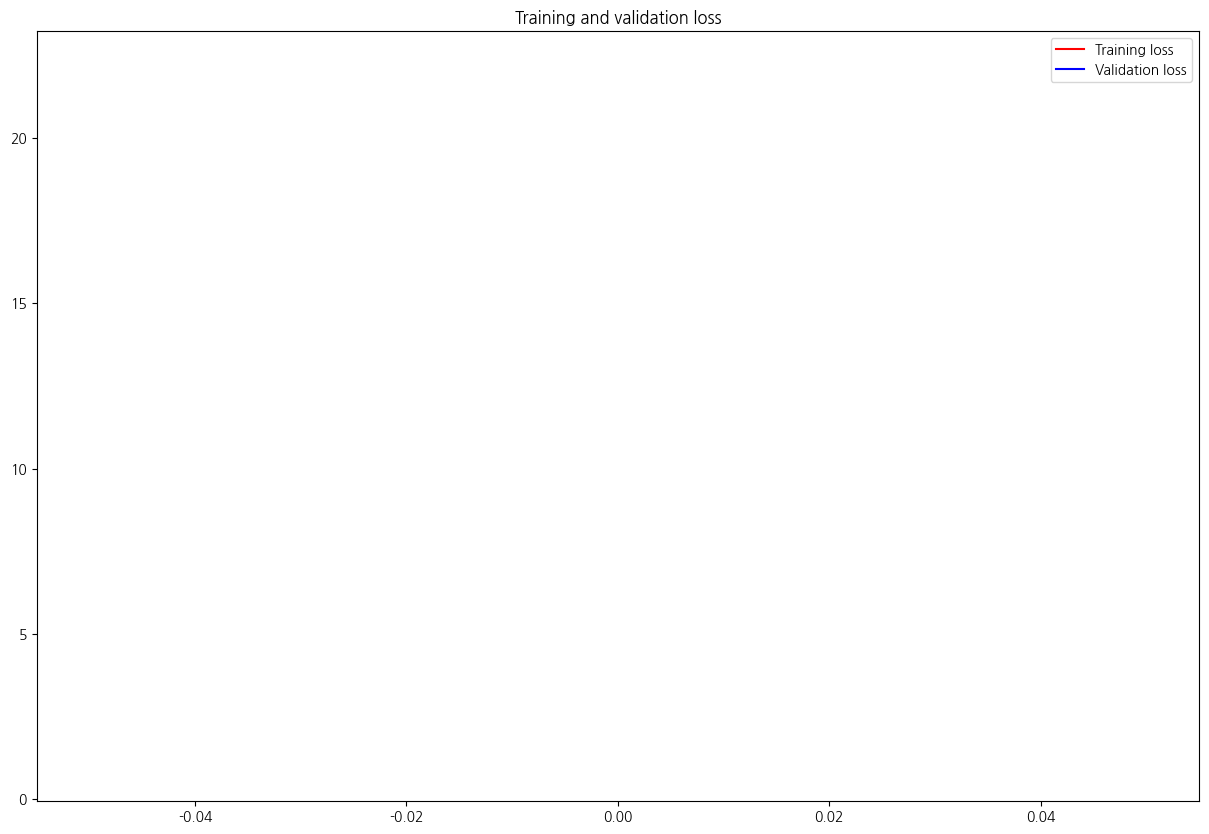

In [36]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(loss))
plt.figure(figsize=(15,10))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## (2) 학습 결과(accuracy) 그래프로 확인

# 6. 학습한 Model 저장

## [Method 1] 모델 자체를 저장

모델 전체를 파일로 저장하고, 불러오는 방법

In [37]:
model.save('CRNN_model_test.h5') #저장될 디렉토리의 경로 저장

#new_model = tf.keras.models.load_model('/content/sample_data/checkpoints/202211281921_crnn_korean_v1/weights.021900.h5')

#test_loss, test_acc = new_model.evaluate(x,  y, verbose=2)

## [Method 2] 가중치를 저장

가중치만 파일로 저장하고, 불러오는 방법

In [38]:
model.save_weights('CRNN_weights_test.h5')

'''
new_model= tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, input_dim=x.shape[1]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(np.unique(y)), activation='softmax')
])

new_model.load_weights('iris_weight')
test_loss, test_acc = new_model.evaluate(x,  y, verbose=2)
'''

"\nnew_model= tf.keras.models.Sequential([\n    tf.keras.layers.Dense(32, input_dim=x.shape[1]),\n    tf.keras.layers.BatchNormalization(),\n    tf.keras.layers.Dropout(0.2),\n    tf.keras.layers.Dense(64, activation='relu'),\n    tf.keras.layers.BatchNormalization(),\n    tf.keras.layers.Dropout(0.2),\n    tf.keras.layers.Dense(len(np.unique(y)), activation='softmax')\n])\n\nnew_model.load_weights('iris_weight')\ntest_loss, test_acc = new_model.evaluate(x,  y, verbose=2)\n"

In [31]:
import matplotlib as mpl

# 유니코드 깨짐현상 해결
mpl.rcParams['axes.unicode_minus'] = False

# 나눔고딕 폰트 적용
plt.rcParams["font.family"] = 'NanumGothic'

NEW epoch


[ WARN:0@343.606] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03385243.png'): can't open/read file: check file path/integrity
[ WARN:0@343.610] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383909.png'): can't open/read file: check file path/integrity
[ WARN:0@343.610] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384627.png'): can't open/read file: check file path/integrity
[ WARN:0@343.619] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383703.png'): can't open/read file: check file path/integrity
[ WARN:0@343.630] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03384789.png'): can't open/read file: check file path/integrity
[ WARN:0@343.645] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./printed/03383443.png'): can't open/read 

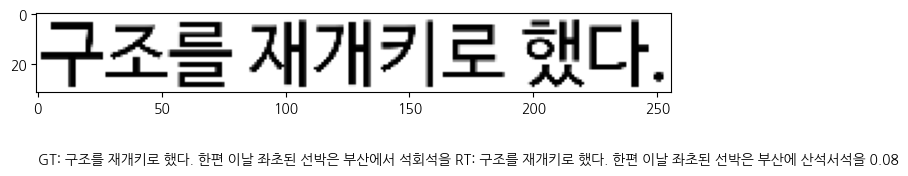

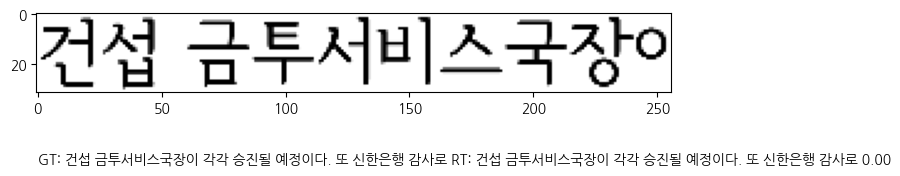

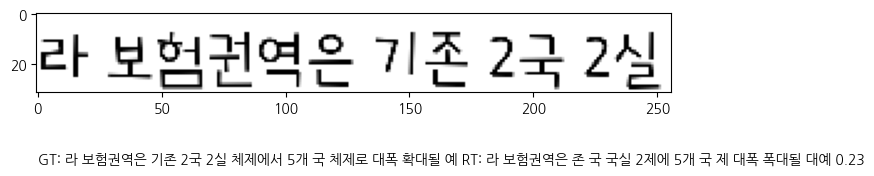

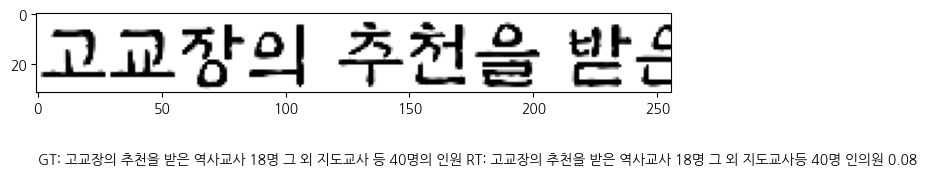

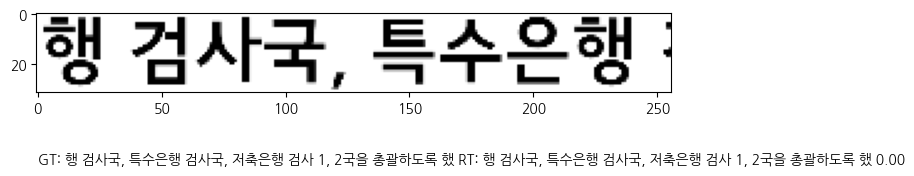

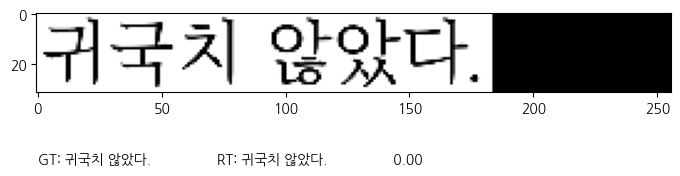

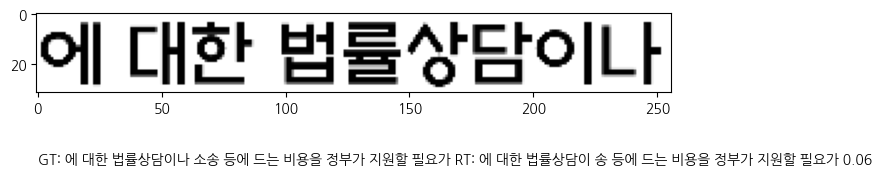

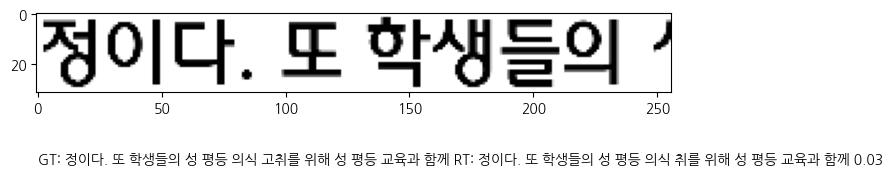

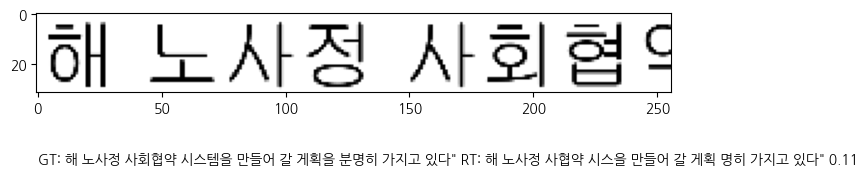

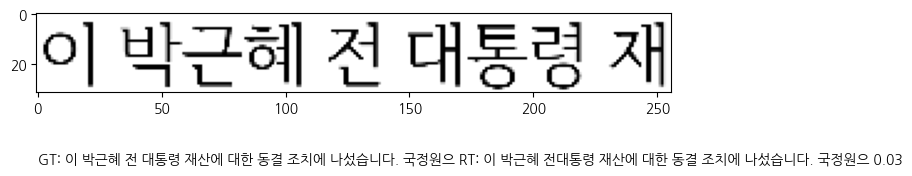

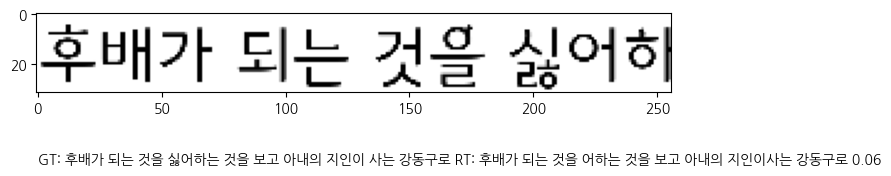

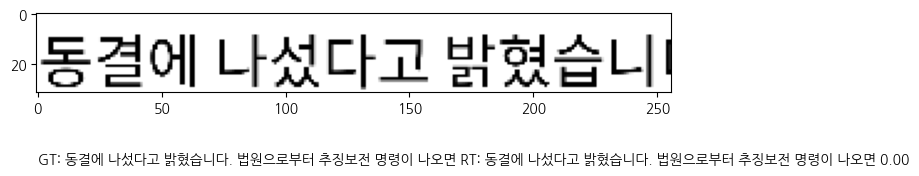

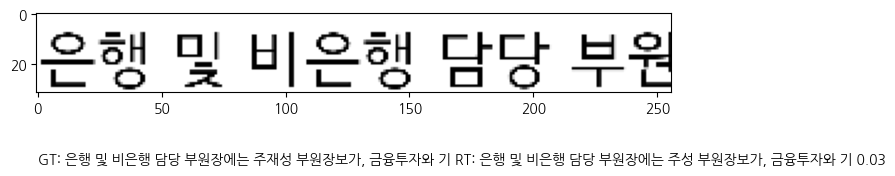

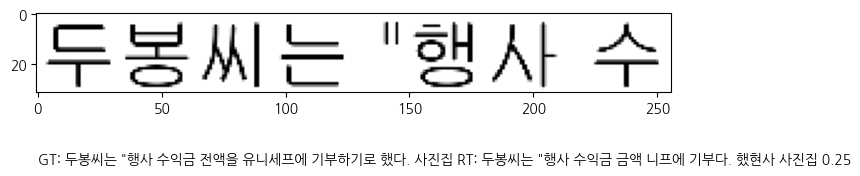

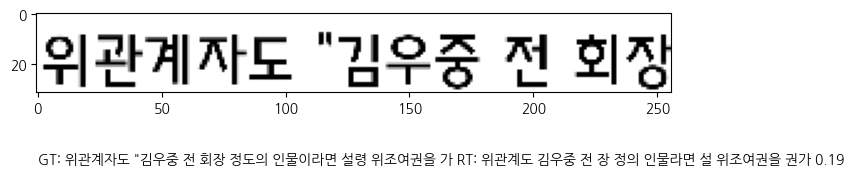

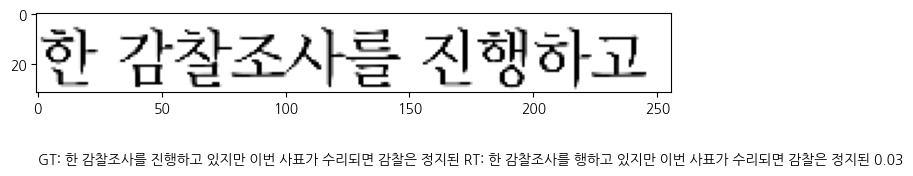

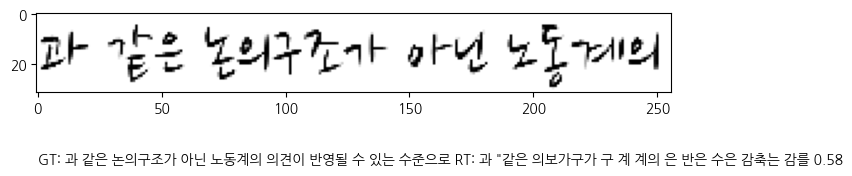

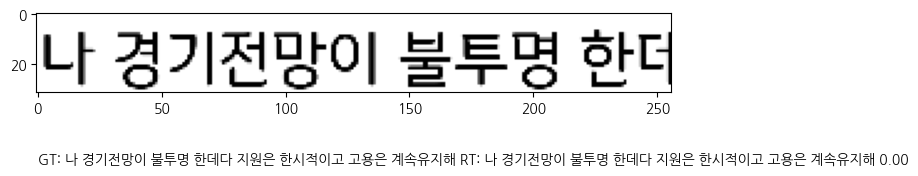

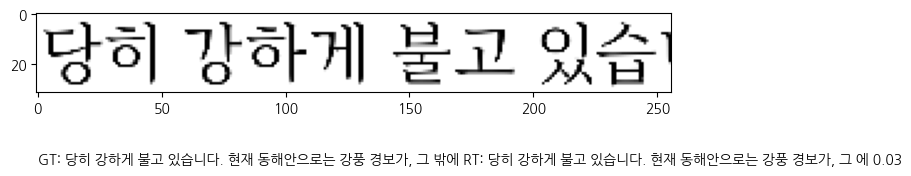

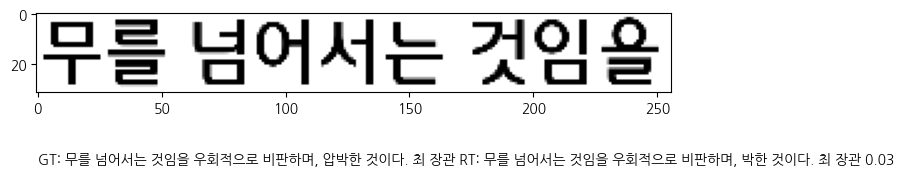

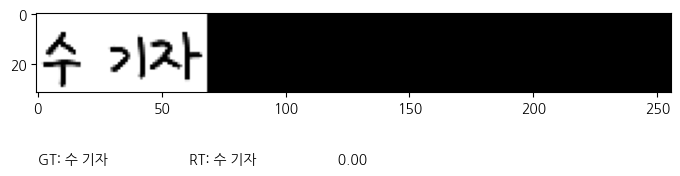

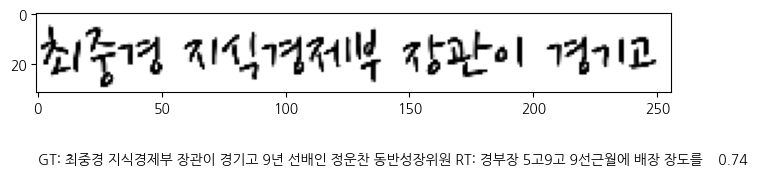

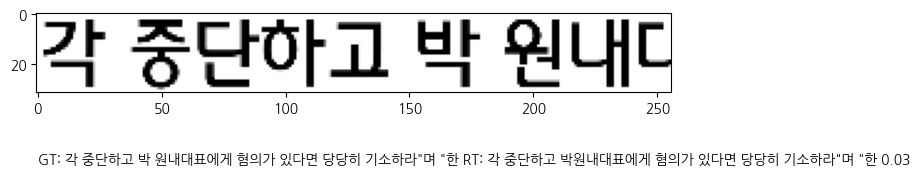

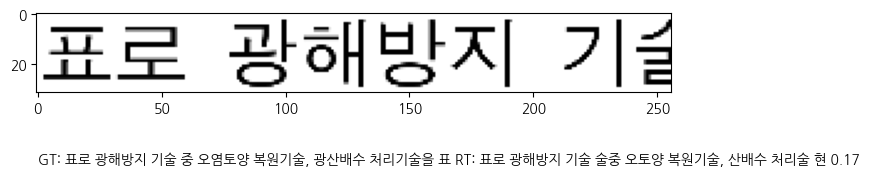

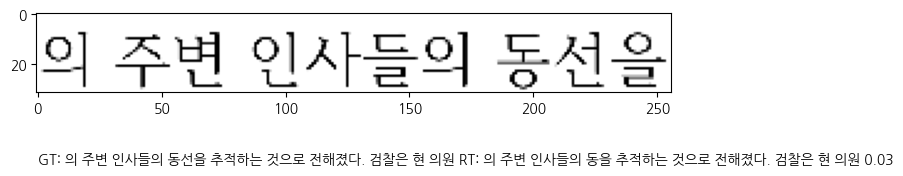

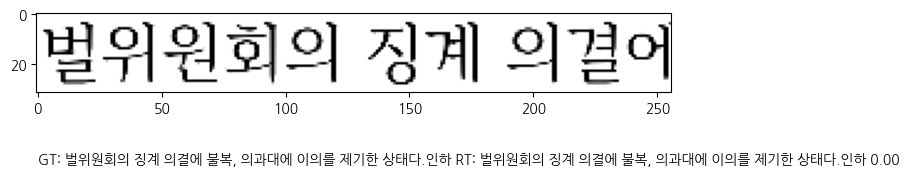

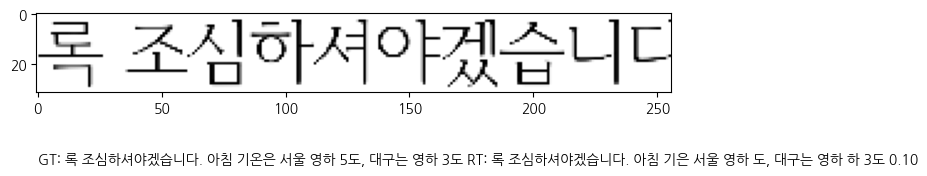

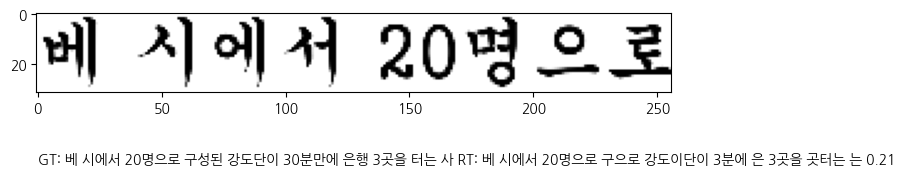

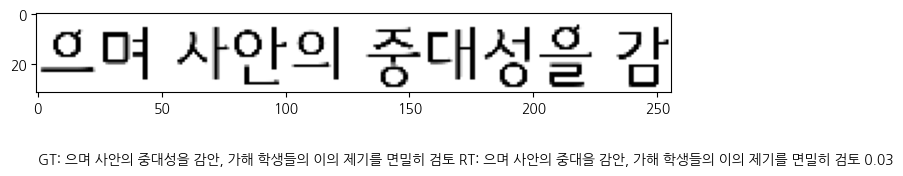

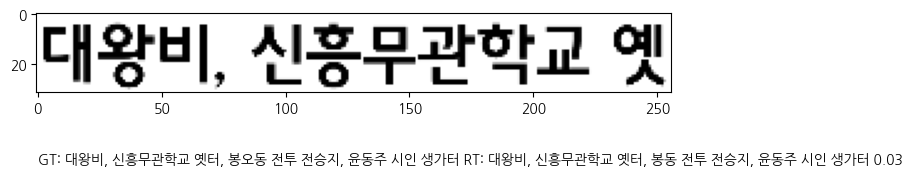

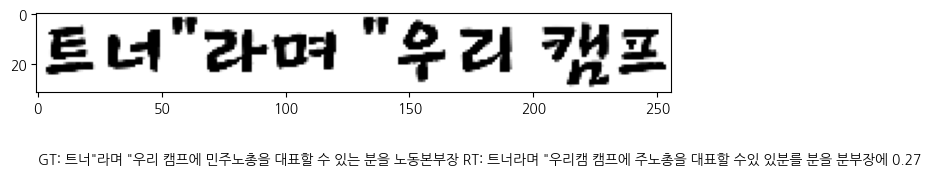

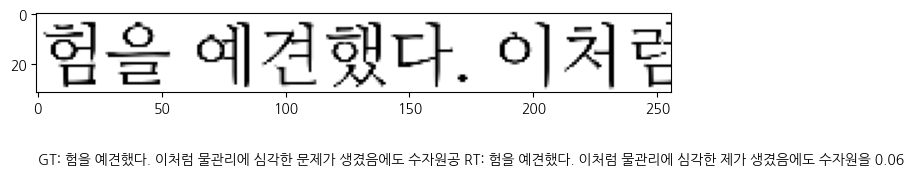

In [32]:
g = gen_val.generate()
d = next(g)

res = model_pred.predict(d[0]['image_input'])

mean_ed = 0
mean_ed_norm = 0

plot_name = 'crnn_korean'

for i in range(32):
    chars = [alphabet[c] for c in np.argmax(res[i], axis=1)]
    gt_str = d[0]['source_str'][i]
    res_str = decode(chars)
    
    ed = editdistance.eval(gt_str, res_str)
    ed_norm = ed / len(gt_str)
    mean_ed += ed
    mean_ed_norm += ed_norm
    
    img = d[0]['image_input'][i][:,:,0].T
    plt.figure(figsize=[10,1.03])
    plt.imshow(img, cmap='gray', interpolation=None)
    ax = plt.gca()
    #plt.text(0, 45, '%s' % (''.join(chars)) )
    plt.text(0, 60, 'GT: %-24s RT: %-24s %0.2f' % (gt_str, res_str, ed_norm))
    
    plt.show()
    
mean_ed /= len(res)
mean_ed_norm /= len(res)
